# Station S3 analysis

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, places, viz_tools, visualisations
import xarray as xr
import pandas as pd
import pickle
import os
import bloomdrivers
import seaborn as sns
import cmocean
import pylab


%matplotlib inline

### To recreate this notebook at a different location, follow these instructions: 

In [5]:
# The path to the directory where the pickle files are stored:
savedir='/ocean/aisabell/MEOPAR/extracted_files'
# Change 'S3' to the location of interest
loc='S3'
# What is the start year and end year+1 of the time range of interest?
startyear=2007
endyear=2021 # does NOT include this value
# Note: What is the model run?

# Note: non-location specific variables only need to be done for each year, not for each location
# Note: xticks in the plots will need to be changed
# Note: 201812 bloom timing variable load and plotting will also need to be removed

1.1363636363636362

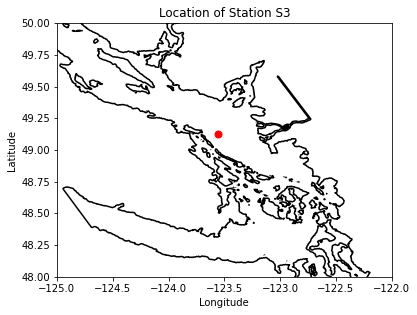

In [6]:
modver='201905'
# lat and lon information for place:
lon,lat=places.PLACES[loc]['lon lat']
# get place information on SalishSeaCast grid:
ij,ii=places.PLACES[loc]['NEMO grid ji']
jw,iw=places.PLACES[loc]['GEM2.5 grid ji']

fig, ax = plt.subplots(1,1,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mesh:
    ax.contour(mesh.nav_lon,mesh.nav_lat,mesh.tmask.isel(t=0,z=0),[0.1,],colors='k')
    tmask=np.array(mesh.tmask)
    gdept_1d=np.array(mesh.gdept_1d)
    e3t_0=np.array(mesh.e3t_0)
ax.plot(lon, lat, '.', markersize=14, color='red')
ax.set_ylim(48,50)
ax.set_xlim(-125,-122)
ax.set_title('Location of Station %s'%loc)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
viz_tools.set_aspect(ax,coords='map')

### Strait of Georgia Region:

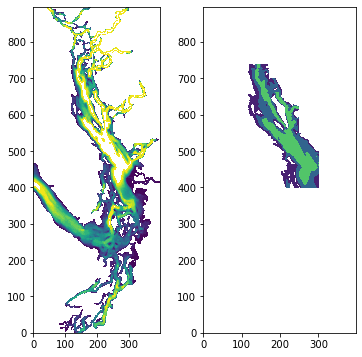

In [7]:
# define sog region:
fig, ax = plt.subplots(1,2,figsize = (6,6))
with xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as bathy:
    bath=np.array(bathy.Bathymetry)
ax[0].contourf(bath,np.arange(0,250,10))
viz_tools.set_aspect(ax[0],coords='grid')
sogmask=np.copy(tmask[:,:,:,:])
sogmask[:,:,740:,:]=0
sogmask[:,:,700:,170:]=0
sogmask[:,:,550:,250:]=0
sogmask[:,:,:,302:]=0
sogmask[:,:,:400,:]=0
sogmask[:,:,:,:100]=0
#sogmask250[bath<250]=0
ax[1].contourf(np.ma.masked_where(sogmask[0,0,:,:]==0,bathy.Bathymetry),[0,100,250,550])

###  *** Stop and check, have you made pickle files for all the years? ***

In [8]:
# loop through years of spring time series (mid feb-june) for bloom timing for 201905 run
years=list()
bloomtime1=list()
bloomtime2=list()
bloomtime3=list()
for year in range(startyear,endyear):
    fname3=f'springBloomTime_{str(year)}_{loc}_{modver}.pkl'
    savepath3=os.path.join(savedir,fname3)
    bio_time0,sno30,sdiat0,sflag0,scili0,diat_alld0,no3_alld0,flag_alld0,cili_alld0,phyto_alld0,\
                 intdiat0,intphyto0,fracdiat0,sphyto0,percdiat0=pickle.load(open(savepath3,'rb'))
    # put code that calculates bloom timing here
    bt1=bloomdrivers.metric1_bloomtime(phyto_alld0,no3_alld0,bio_time0)
    bt2=bloomdrivers.metric2_bloomtime(sphyto0,sno30,bio_time0)
    bt3=bloomdrivers.metric3_bloomtime(sphyto0,sno30,bio_time0)
    years.append(year)
    bloomtime1.append(bt1)
    bloomtime2.append(bt2)
    bloomtime3.append(bt3)   
years=np.array(years)
bloomtime1=np.array(bloomtime1)
bloomtime2=np.array(bloomtime2)
bloomtime3=np.array(bloomtime3)

# get year day
yearday1=et.datetimeToYD(bloomtime1)  # convert to year day tool
yearday2=et.datetimeToYD(bloomtime2)
yearday3=et.datetimeToYD(bloomtime3)

### Combine separate year files into arrays:

In [9]:
# loop through years (for location specific drivers)

years=list()
windjan=list()
windfeb=list()
windmar=list()
solarjan=list()
solarfeb=list()
solarmar=list()
parjan=list()
parfeb=list()
parmar=list()
tempjan=list()
tempfeb=list()
tempmar=list()
saljan=list()
salfeb=list()
salmar=list()
zoojan=list()
zoofeb=list()
zoomar=list()
mesozoojan=list()
mesozoofeb=list()
mesozoomar=list()
microzoojan=list()
microzoofeb=list()
microzoomar=list()
intzoojan=list()
intzoofeb=list()
intzoomar=list()
intmesozoojan=list()
intmesozoofeb=list()
intmesozoomar=list()
intmicrozoojan=list()
intmicrozoofeb=list()
intmicrozoomar=list()
midno3jan=list()
midno3feb=list()
midno3mar=list()

for year in range(startyear,endyear):
    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    # put code that calculates drivers here
    wind=bloomdrivers.D1_3monthly_avg(twind,wspeed)
    solar=bloomdrivers.D1_3monthly_avg(twind,solar)
    par=bloomdrivers.D1_3monthly_avg(bio_time,spar)
    temp=bloomdrivers.D1_3monthly_avg(grid_time,temp)
    sal=bloomdrivers.D1_3monthly_avg(grid_time,salinity)
    zoo=bloomdrivers.D2_3monthly_avg(bio_time,zoop_alld)
    mesozoo=bloomdrivers.D2_3monthly_avg(bio_time,mesozoo_alld)
    microzoo=bloomdrivers.D2_3monthly_avg(bio_time,microzoo_alld)
    intzoo=bloomdrivers.D1_3monthly_avg(bio_time,intzoop)
    intmesozoo=bloomdrivers.D1_3monthly_avg(bio_time,intmesoz)
    intmicrozoo=bloomdrivers.D1_3monthly_avg(bio_time,intmicroz)
    midno3=bloomdrivers.D1_3monthly_avg(bio_time,no3_30to90m)
    
    years.append(year)
    windjan.append(wind[0])
    windfeb.append(wind[1])
    windmar.append(wind[2])   
    solarjan.append(solar[0])
    solarfeb.append(solar[1])
    solarmar.append(solar[2])
    parjan.append(par[0])
    parfeb.append(par[1])
    parmar.append(par[2])
    tempjan.append(temp[0])
    tempfeb.append(temp[1])
    tempmar.append(temp[2])
    saljan.append(sal[0])
    salfeb.append(sal[1])
    salmar.append(sal[2])
    zoojan.append(zoo[0])
    zoofeb.append(zoo[1])
    zoomar.append(zoo[2])
    mesozoojan.append(mesozoo[0])
    mesozoofeb.append(mesozoo[1])
    mesozoomar.append(mesozoo[2])
    microzoojan.append(microzoo[0])
    microzoofeb.append(microzoo[1])
    microzoomar.append(microzoo[2])
    intzoojan.append(intzoo[0])
    intzoofeb.append(intzoo[1])
    intzoomar.append(intzoo[2])
    intmesozoojan.append(intmesozoo[0])
    intmesozoofeb.append(intmesozoo[1])
    intmesozoomar.append(intmesozoo[2])
    intmicrozoojan.append(intmicrozoo[0])
    intmicrozoofeb.append(intmicrozoo[1])
    intmicrozoomar.append(intmicrozoo[2])
    midno3jan.append(midno3[0])
    midno3feb.append(midno3[1])
    midno3mar.append(midno3[2])

years=np.array(years)
windjan=np.array(windjan)
windfeb=np.array(windfeb)
windmar=np.array(windmar)
solarjan=np.array(solarjan)
solarfeb=np.array(solarfeb)
solarmar=np.array(solarmar)
parjan=np.array(parjan)
parfeb=np.array(parfeb)
parmar=np.array(parmar)
tempjan=np.array(tempjan)
tempfeb=np.array(tempfeb)
tempmar=np.array(tempmar)
saljan=np.array(saljan)
salfeb=np.array(salfeb)
salmar=np.array(salmar)
zoojan=np.array(zoojan)
zoofeb=np.array(zoofeb)
zoomar=np.array(zoomar)
mesozoojan=np.array(mesozoojan)
mesozoofeb=np.array(mesozoofeb)
mesozoomar=np.array(mesozoomar)
microzoojan=np.array(microzoojan)
microzoofeb=np.array(microzoofeb)
microzoomar=np.array(microzoomar)
intzoojan=np.array(intzoojan)
intzoofeb=np.array(intzoofeb)
intzoomar=np.array(intzoomar)
intmesozoojan=np.array(intmesozoojan)
intmesozoofeb=np.array(intmesozoofeb)
intmesozoomar=np.array(intmesozoomar)
intmicrozoojan=np.array(intmicrozoojan)
intmicrozoofeb=np.array(intmicrozoofeb)
intmicrozoomar=np.array(intmicrozoomar)
midno3jan=np.array(midno3jan)
midno3feb=np.array(midno3feb)
midno3mar=np.array(midno3mar)

In [10]:
# loop through years (for non-location specific drivers)
fraserjan=list()
fraserfeb=list()
frasermar=list()
deepno3jan=list()
deepno3feb=list()
deepno3mar=list()

for year in range(startyear,endyear):
    fname2=f'JanToMarch_TimeSeries_{year}_{modver}.pkl'
    savepath2=os.path.join(savedir,fname2)
    no3_past250m,riv_time,rivFlow=pickle.load(open(savepath2,'rb'))
    # Code that calculates drivers here
    fraser=bloomdrivers.D1_3monthly_avg2(riv_time,rivFlow)
    fraserjan.append(fraser[0])
    fraserfeb.append(fraser[1])
    frasermar.append(fraser[2])

    fname=f'JanToMarch_TimeSeries_{year}_{loc}_{modver}.pkl'
    savepath=os.path.join(savedir,fname)
    bio_time,diat_alld,no3_alld,flag_alld,cili_alld,microzoo_alld,mesozoo_alld,\
            intdiat,intphyto,spar,intmesoz,intmicroz,grid_time,temp,salinity,u_wind,v_wind,twind,\
            solar,no3_30to90m,sno3,sdiat,sflag,scili,intzoop,fracdiat,zoop_alld,sphyto,phyto_alld,\
            percdiat,wspeed,winddirec=pickle.load(open(savepath,'rb'))
    deepno3=bloomdrivers.D1_3monthly_avg(bio_time,no3_past250m)
 
    deepno3jan.append(deepno3[0])
    deepno3feb.append(deepno3[1])
    deepno3mar.append(deepno3[2])

fraserjan=np.array(fraserjan)
fraserfeb=np.array(fraserfeb)
frasermar=np.array(frasermar)
deepno3jan=np.array(deepno3jan)
deepno3feb=np.array(deepno3feb)
deepno3mar=np.array(deepno3mar)

### Load mixing variables

In [11]:
# for T grid depth:
startd=dt.datetime(2015,1,1) # some date to get depth
endd=dt.datetime(2015,1,2)
basedir='/results2/SalishSea/nowcast-green.201905/'
nam_fmt='nowcast'
flen=1 # files contain 1 day of data each
tres=24 # 1: hourly resolution; 24: daily resolution
flist=et.index_model_files(startd,endd,basedir,nam_fmt,flen,"grid_T",tres)
with xr.open_mfdataset(flist['paths']) as gridt:
    depth_T=np.array(gridt.deptht)

# loop through years (for mixing drivers)

halojan=list()
halofeb=list()
halomar=list()
turbojan=list()
turbofeb=list()
turbomar=list()
densdiff5jan=list()
densdiff10jan=list()
densdiff15jan=list()
densdiff20jan=list()
densdiff25jan=list()
densdiff30jan=list()
densdiff5feb=list()
densdiff10feb=list()
densdiff15feb=list()
densdiff20feb=list()
densdiff25feb=list()
densdiff30feb=list()
densdiff5mar=list()
densdiff10mar=list()
densdiff15mar=list()
densdiff20mar=list()
densdiff25mar=list()
densdiff30mar=list()
eddy15jan=list()
eddy15feb=list()
eddy15mar=list()
eddy30jan=list()
eddy30feb=list()
eddy30mar=list()

for year in range(startyear,endyear):
    fname4=f'JanToMarch_Mixing_{year}_{loc}_{modver}.pkl'
    savepath4=os.path.join(savedir,fname4)
    halocline,eddy,depth,grid_time,temp,salinity=pickle.load(open(savepath4,'rb'))
   
    # halocline
    halo=bloomdrivers.D1_3monthly_avg(grid_time,halocline)
    halojan.append(halo[0])
    halofeb.append(halo[1])
    halomar.append(halo[2])
    # turbocline
    turbo=bloomdrivers.turbo(eddy,grid_time,depth_T)
    turbojan.append(turbo[0])
    turbofeb.append(turbo[1])
    turbomar.append(turbo[2])
    # density differences
    dict_diffs=bloomdrivers.density_diff(salinity,temp,grid_time)
    values=dict_diffs.values()
    all_diffs=list(values)
    densdiff5jan.append(all_diffs[0])
    densdiff10jan.append(all_diffs[3])
    densdiff15jan.append(all_diffs[6])
    densdiff20jan.append(all_diffs[9])
    densdiff25jan.append(all_diffs[12])
    densdiff30jan.append(all_diffs[15])
    densdiff5feb.append(all_diffs[1])
    densdiff10feb.append(all_diffs[4])
    densdiff15feb.append(all_diffs[7])
    densdiff20feb.append(all_diffs[10])
    densdiff25feb.append(all_diffs[13])
    densdiff30feb.append(all_diffs[16])
    densdiff5mar.append(all_diffs[2])
    densdiff10mar.append(all_diffs[5])
    densdiff15mar.append(all_diffs[8])
    densdiff20mar.append(all_diffs[11])
    densdiff25mar.append(all_diffs[14])
    densdiff30mar.append(all_diffs[17])
    # average eddy diffusivity 
    avg_eddy=bloomdrivers.avg_eddy(eddy,grid_time,ij,ii)
    eddy15jan.append(avg_eddy[0])
    eddy15feb.append(avg_eddy[1])
    eddy15mar.append(avg_eddy[2])
    eddy30jan.append(avg_eddy[3])
    eddy30feb.append(avg_eddy[4])
    eddy30mar.append(avg_eddy[5])

halojan=np.array(halojan)
halofeb=np.array(halofeb)
halomar=np.array(halomar)
turbojan=np.array(turbojan)
turbofeb=np.array(turbofeb)
turbomar=np.array(turbomar)
densdiff5jan=np.array(densdiff5jan)
densdiff10jan=np.array(densdiff10jan)
densdiff15jan=np.array(densdiff15jan)
densdiff20jan=np.array(densdiff20jan)
densdiff25jan=np.array(densdiff25jan)
densdiff30jan=np.array(densdiff30jan)
densdiff5feb=np.array(densdiff5feb)
densdiff10feb=np.array(densdiff10feb)
densdiff15feb=np.array(densdiff15feb)
densdiff20feb=np.array(densdiff20feb)
densdiff25feb=np.array(densdiff25feb)
densdiff30feb=np.array(densdiff30feb)
densdiff5mar=np.array(densdiff5mar)
densdiff10mar=np.array(densdiff10mar)
densdiff15mar=np.array(densdiff15mar)
densdiff20mar=np.array(densdiff20mar)
densdiff25mar=np.array(densdiff25mar)
densdiff30mar=np.array(densdiff30mar)
eddy15jan=np.array(eddy15jan)
eddy15feb=np.array(eddy15feb)
eddy15mar=np.array(eddy15mar)
eddy30jan=np.array(eddy30jan)
eddy30feb=np.array(eddy30feb)
eddy30mar=np.array(eddy30mar)

In [10]:
# January dataframe
dfjan=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windjan,'solar':solarjan,
                  'temp':tempjan,'sal':saljan,'midno3':midno3jan,'fraser':fraserjan,'deepno3':deepno3jan,'halocline':halojan,
                   'turbocline':turbojan,'eddy15jan':eddy15jan,'eddy30jan':eddy30jan,'densdiff5jan':densdiff5jan,'densdiff10jan':densdiff10jan,
                    'densdiff15jan':densdiff15jan,'densdiff20jan':densdiff20jan,'densdiff25jan':densdiff25jan,'densdiff30jan':densdiff30jan})
# February dataframe
dffeb=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windfeb,'solar':solarfeb,
                  'temp':tempfeb,'sal':salfeb,'midno3':midno3feb,'fraser':fraserfeb,'deepno3':deepno3feb,'halocline':halofeb,
                   'turbocline':turbofeb,'eddy15feb':eddy15feb,'eddy30feb':eddy30feb,'densdiff5feb':densdiff5feb,'densdiff10feb':densdiff10feb,
                    'densdiff15feb':densdiff15feb,'densdiff20feb':densdiff20feb,'densdiff25feb':densdiff25feb,'densdiff30feb':densdiff30feb})
# March dataframe
dfmar=pd.DataFrame({'metric1':yearday1, 'metric2':yearday2, 'metric3':yearday3, 'wind':windmar,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocline':halomar,
                   'turbocline':turbomar,'eddy15mar':eddy15mar,'eddy30mar':eddy30mar,'densdiff5mar':densdiff5mar,'densdiff10mar':densdiff10mar,
                    'densdiff15mar':densdiff15mar,'densdiff20mar':densdiff20mar,'densdiff25mar':densdiff25mar,'densdiff30mar':densdiff30mar})

In [10]:
dfjan.cov()

metric1     metric2     metric3         wind       solar  \
metric1        167.192308  137.846154  128.192308    23.129078  -12.446660   
metric2        137.846154  179.494505  145.901099   281.294891   -4.938732   
metric3        128.192308  145.901099  132.335165   166.893530   -8.356181   
wind            23.129078  281.294891  166.893530  8094.426045 -458.025790   
solar          -12.446660   -4.938732   -8.356181  -458.025790   67.435320   
temp            -3.737684   -4.977896   -4.223339    13.867379   -3.160387   
sal             -2.507605   -0.353398   -1.419171    40.699889   -2.825547   
midno3           4.392353    5.227610    4.309779    23.576396   -1.706040   
fraser        -600.550070 -778.202736 -801.435591  -936.027025  -23.614641   
deepno3          6.741225    7.644347    7.227635    14.378985   -1.121300   
halocline      -13.428416   -1.983367   -4.460019   177.962411  -10.159804   
turbocline      -6.017705    1.886995    0.386595   162.275376  -12.189703   
eddy15jan       -0.016625    0.006333   -0.001097     0.579936   -0.039093   
eddy30jan       -0.013287    0.000114   -0.003846     0.336449   -0.023628   
densdiff5jan     0.660899   -0.884057   -0.404332   -31.631295    1.603540   
densdiff10jan    1.065900   -0.708931    0.110955   -32.999129    1.714917   
densdiff15jan    1.024604   -0.724266    0.193712   -31.827223    1.721691   
densdiff20jan    1.226255   -0.520980    0.420024   -31.015671    1.748888   
densdiff25jan    1.324041   -0.399765    0.537432   -30.687314    1.795399   
densdiff30jan    1.436117   -0.249348    0.685603   -29.939353    1.839209   

                    temp        sal     midno3        fraser    deepno3  \
metric1        -3.737684  -2.507605   4.392353   -600.550070   6.741225   
metric2        -4.977896  -0.353398   5.227610   -778.202736   7.644347   
metric3        -4.223339  -1.419171   4.309779   -801.435591   7.227635   
wind           13.867379  40.699889  23.576396   -936.027025  14.378985   
solar          -3.160387  -2.825547  -1.706040    -23.614641  -1.121300   
temp            0.487680   0.404520  -0.077289     44.577452  -0.310055   
sal             0.404520   0.863035   0.104467    -18.401152  -0.248327   
midno3         -0.077289   0.104467   0.570821    -54.905988   0.519644   
fraser         44.577452 -18.401152 -54.905988  25704.091440 -43.359271   
deepno3        -0.310055  -0.248327   0.519644    -43.359271   0.880773   
halocline       0.720811   1.601088   0.122078      3.227778  -0.338169   
turbocline      0.644098   1.385239   0.296624    -53.888336  -0.130626   
eddy15jan       0.001745   0.003647   0.001469     -0.032088   0.000194   
eddy30jan       0.001151   0.002234   0.000697     -0.019895  -0.000173   
densdiff5jan   -0.134744  -0.351517  -0.031115      5.228379   0.028637   
densdiff10jan  -0.220948  -0.512916  -0.027113     -3.252128   0.092383   
densdiff15jan  -0.246962  -0.566245  -0.019738     -4.681109   0.123393   
densdiff20jan  -0.267813  -0.605198  -0.017131     -3.638878   0.146730   
densdiff25jan  -0.277333  -0.618341  -0.021077     -2.685869   0.151917   
densdiff30jan  -0.286708  -0.629426  -0.025254     -1.360753   0.158164   

                halocline  turbocline  eddy15jan  eddy30jan  densdiff5jan  \
metric1        -13.428416   -6.017705  -0.016625  -0.013287      0.660899   
metric2         -1.983367    1.886995   0.006333   0.000114     -0.884057   
metric3         -4.460019    0.386595  -0.001097  -0.003846     -0.404332   
wind           177.962411  162.275376   0.579936   0.336449    -31.631295   
solar          -10.159804  -12.189703  -0.039093  -0.023628      1.603540   
temp             0.720811    0.644098   0.001745   0.001151     -0.134744   
sal              1.601088    1.385239   0.003647   0.002234     -0.351517   
midno3           0.122078    0.296624   0.001469   0.000697     -0.031115   
fraser           3.227778  -53.888336  -0.032088  -0.019895      5.228379   
deepno3         -0.338169   -0.13

In [11]:
dffeb.cov()

metric1      metric2      metric3         wind       solar  \
metric1        167.192308   137.846154   128.192308   274.279459  -53.858452   
metric2        137.846154   179.494505   145.901099   360.325660  -28.377121   
metric3        128.192308   145.901099   132.335165   291.662420  -37.739568   
wind           274.279459   360.325660   291.662420  2108.504590 -133.188560   
solar          -53.858452   -28.377121   -37.739568  -133.188560   58.542495   
temp            -0.713898    -6.032933    -4.270886   -10.889928   -0.877576   
sal             -4.898713    -5.024165    -5.689764    15.694070    2.507346   
midno3           3.904678     4.232697     3.862083     9.299857   -1.635060   
fraser        -939.299268 -2148.530053 -1862.155986 -5281.416721  240.859673   
deepno3          6.694636     7.522579     7.144473    15.042285   -3.642172   
halocline       -4.389741     0.747593     0.061211    53.214231    1.174798   
turbocline       0.631248     3.967210     1.533953    64.173175    0.183618   
eddy15feb        0.014635     0.022937     0.015185     0.178380   -0.006591   
eddy30feb        0.007819     0.012323     0.008215     0.095038   -0.003214   
densdiff5feb     2.383530     1.995206     1.965924   -12.413162   -0.974991   
densdiff10feb    3.761208     3.737160     3.684893   -15.792326   -1.633321   
densdiff15feb    3.909286     4.064137     4.123033   -15.580416   -1.783844   
densdiff20feb    3.847092     4.046173     4.231658   -14.922727   -1.923382   
densdiff25feb    3.887294     4.081392     4.305993   -14.546365   -1.958474   
densdiff30feb    3.985908     4.123631     4.420662   -14.209287   -2.013415   

                     temp        sal      midno3         fraser    deepno3  \
metric1         -0.713898  -4.898713    3.904678    -939.299268   6.694636   
metric2         -6.032933  -5.024165    4.232697   -2148.530053   7.522579   
metric3         -4.270886  -5.689764    3.862083   -1862.155986   7.144473   
wind           -10.889928  15.694070    9.299857   -5281.416721  15.042285   
solar           -0.877576   2.507346   -1.635060     240.859673  -3.642172   
temp             0.714746   0.317722   -0.152104     183.593070  -0.308140   
sal              0.317722   1.535570    0.018919     -60.189150  -0.645027   
midno3          -0.152104   0.018919    0.473593    -161.052481   0.426217   
fraser         183.593070 -60.189150 -161.052481  122323.912955 -76.481005   
deepno3         -0.308140  -0.645027    0.426217     -76.481005   0.869508   
halocline       -0.157110   1.301662   -0.012849    -134.642912  -0.216816   
turbocline      -0.024808   1.796420    0.350044    -227.672953  -0.167364   
eddy15feb       -0.000120   0.003289    0.001098      -0.445890   0.000629   
eddy30feb       -0.000024   0.001779    0.000633      -0.236513   0.000366   
densdiff5feb    -0.063457  -0.621843    0.108866       7.861906   0.289162   
densdiff10feb   -0.203240  -1.004808    0.099354       8.799545   0.451036   
densdiff15feb   -0.249643  -1.111158    0.059863      12.802585   0.468765   
densdiff20feb   -0.260430  -1.147287    0.043926      16.051097   0.480905   
densdiff25feb   -0.264205  -1.154864    0.041519      15.993412   0.485948   
densdiff30feb   -0.265582  -1.165371    0.040145      15.701236   0.492192   

                halocline  turbocline  eddy15feb  eddy30feb  densdiff5feb  \
metric1         -4.389741    0.631248   0.014635   0.007819      2.383530   
metric2          0.747593    3.967210   0.022937   0.012323      1.995206   
metric3          0.061211    1.533953   0.015185   0.008215      1.965924   
wind            53.214231   64.173175   0.178380   0.095038    -12.413162   
solar            1.174798    0.183618  -0.006591  -0.003214     -0.974991   
temp            -0.157110   -0.024808  -0.000120  -0.000024     -0.063457   
sal              1.301662    1.796420   0.003289   0.001779     -0.621843   
midno3          -0.012849    0.350044   0.001098   0.000633      0.108866   
frase

In [12]:
dfmar.cov()

metric1      metric2      metric3         wind        solar  \
metric1        167.192308   137.846154   128.192308   683.907352  -182.929908   
metric2        137.846154   179.494505   145.901099   754.719649  -181.010106   
metric3        128.192308   145.901099   132.335165   648.325174  -163.303261   
wind           683.907352   754.719649   648.325174  5149.923947 -1106.450749   
solar         -182.929908  -181.010106  -163.303261 -1106.450749   401.115077   
temp            -2.243489    -6.634223    -4.494384   -20.041112     2.802207   
sal              4.867424     5.431145     4.504952    33.947953    -6.910096   
midno3           5.951665     7.012743     6.459397    35.910364    -5.339316   
fraser        -850.715675 -3185.425422 -2129.210389 -2988.681860 -1722.072976   
deepno3          6.772832     7.515965     7.127748    42.878490    -8.563671   
halocline       12.937388    13.697898    11.296432   135.845906   -19.872191   
turbocline      18.279703    19.697049    17.132427   135.405965   -26.560892   
eddy15mar        0.046715     0.054050     0.046704     0.416705    -0.070921   
eddy30mar        0.025753     0.030024     0.025858     0.232060    -0.039276   
densdiff5mar    -3.070548    -3.251196    -2.640806   -19.310034     4.376455   
densdiff10mar   -4.896818    -4.666661    -4.001602   -30.594037     6.205914   
densdiff15mar   -5.058046    -5.082467    -4.341096   -34.652763     7.207849   
densdiff20mar   -4.947842    -5.053005    -4.320247   -34.684207     7.407072   
densdiff25mar   -4.897806    -5.005605    -4.280629   -34.296572     7.353046   
densdiff30mar   -4.840299    -4.959847    -4.238613   -33.812889     7.291933   

                     temp         sal      midno3         fraser    deepno3  \
metric1         -2.243489    4.867424    5.951665    -850.715675   6.772832   
metric2         -6.634223    5.431145    7.012743   -3185.425422   7.515965   
metric3         -4.494384    4.504952    6.459397   -2129.210389   7.127748   
wind           -20.041112   33.947953   35.910364   -2988.681860  42.878490   
solar            2.802207   -6.910096   -5.339316   -1722.072976  -8.563671   
temp             0.460763   -0.076910   -0.322029     238.741716  -0.324212   
sal             -0.076910    0.896922    0.248659    -169.872150  -0.129176   
midno3          -0.322029    0.248659    0.673588    -229.004563   0.527731   
fraser         238.741716 -169.872150 -229.004563  234451.617848 -54.719142   
deepno3         -0.324212   -0.129176    0.527731     -54.719142   0.853843   
halocline       -0.253645    1.876504    0.807674    -126.928343   0.670977   
turbocline      -0.443459    1.316921    0.967883    -175.790745   0.914768   
eddy15mar       -0.001541    0.003553    0.003202      -0.516486   0.003425   
eddy30mar       -0.000872    0.002003    0.001763      -0.286979   0.001934   
densdiff5mar     0.027931   -0.455622   -0.124549      75.990121   0.056219   
densdiff10mar    0.024538   -0.706000   -0.184844      98.572787   0.085238   
densdiff15mar    0.040026   -0.773812   -0.199858     102.095629   0.077538   
densdiff20mar    0.041684   -0.773844   -0.189961      97.690653   0.068121   
densdiff25mar    0.041229   -0.769913   -0.184451      96.936242   0.066951   
densdiff30mar    0.041877   -0.761883   -0.177915      96.272999   0.065363   

                halocline  turbocline  eddy15mar  eddy30mar  densdiff5mar  \
metric1         12.937388   18.279703   0.046715   0.025753     -3.070548   
metric2         13.697898   19.697049   0.054050   0.030024     -3.251196   
metric3         11.296432   17.132427   0.046704   0.025858     -2.640806   
wind           135.845906  135.405965   0.416705   0.232060    -19.310034   
solar          -19.872191  -26.560892  -0.070921  -0.039276      4.376455   
temp            -0.253645   -0.443459  -0.001541  -0.000872      0.027931   
sal              1.876504    1.316921   0.003553   0.002003     -0.455622   
midno3           0.807674    0.967883   

### Correlation matrix for January Values


<AxesSubplot:>

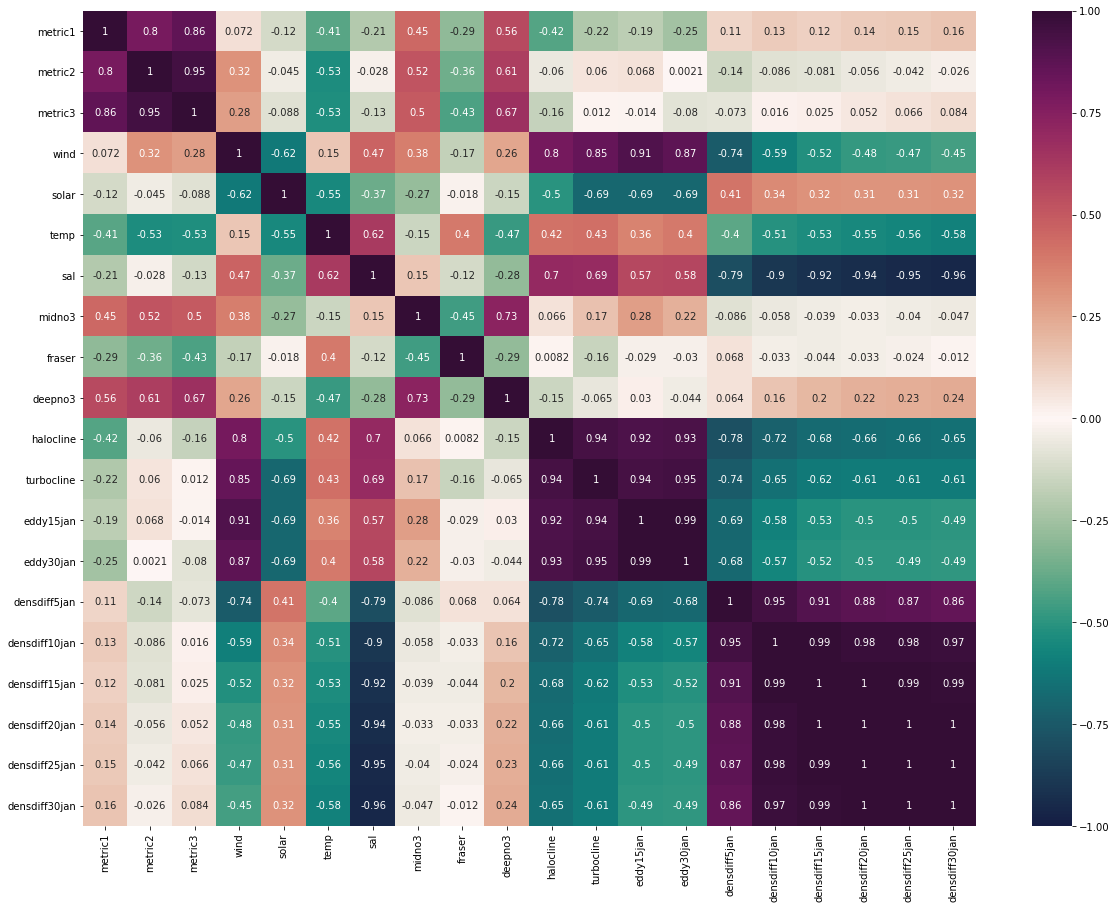

In [11]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfjan.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for February Values

<AxesSubplot:>

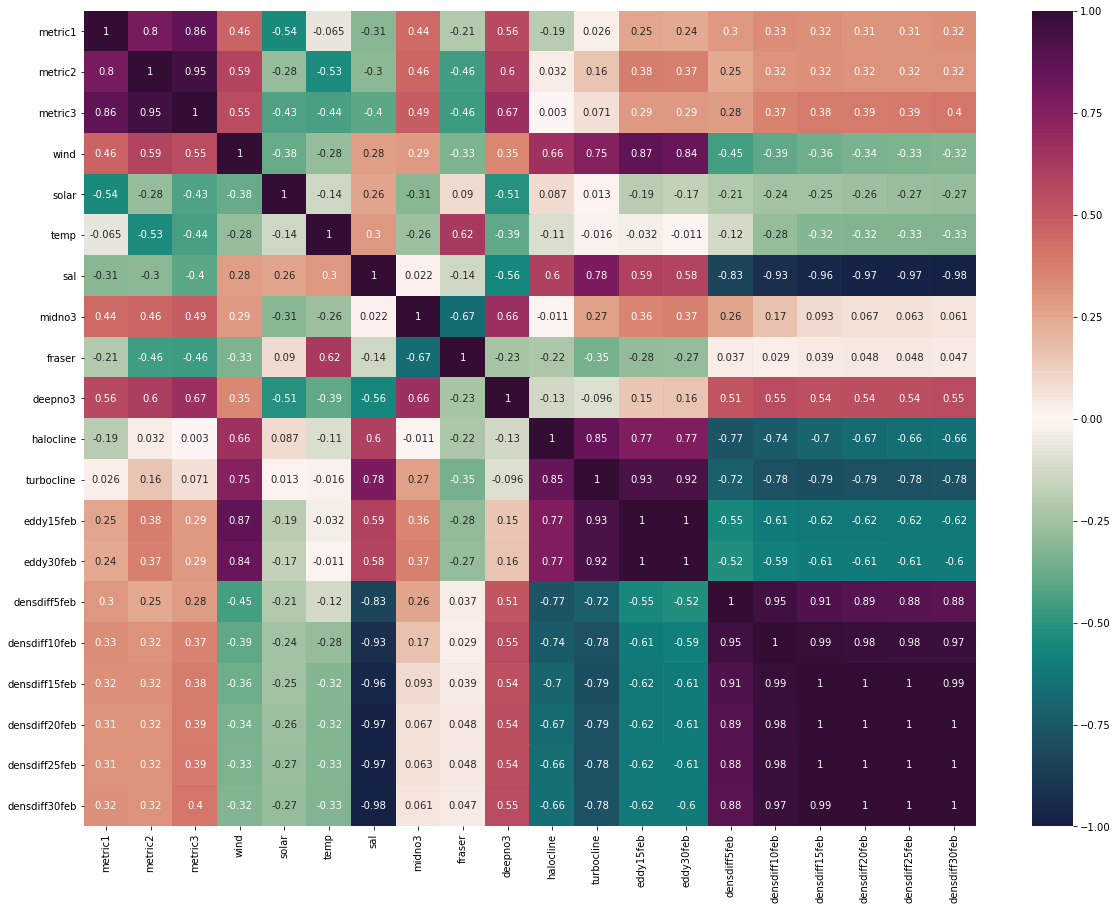

In [14]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffeb.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation matrix for March Values

<AxesSubplot:>

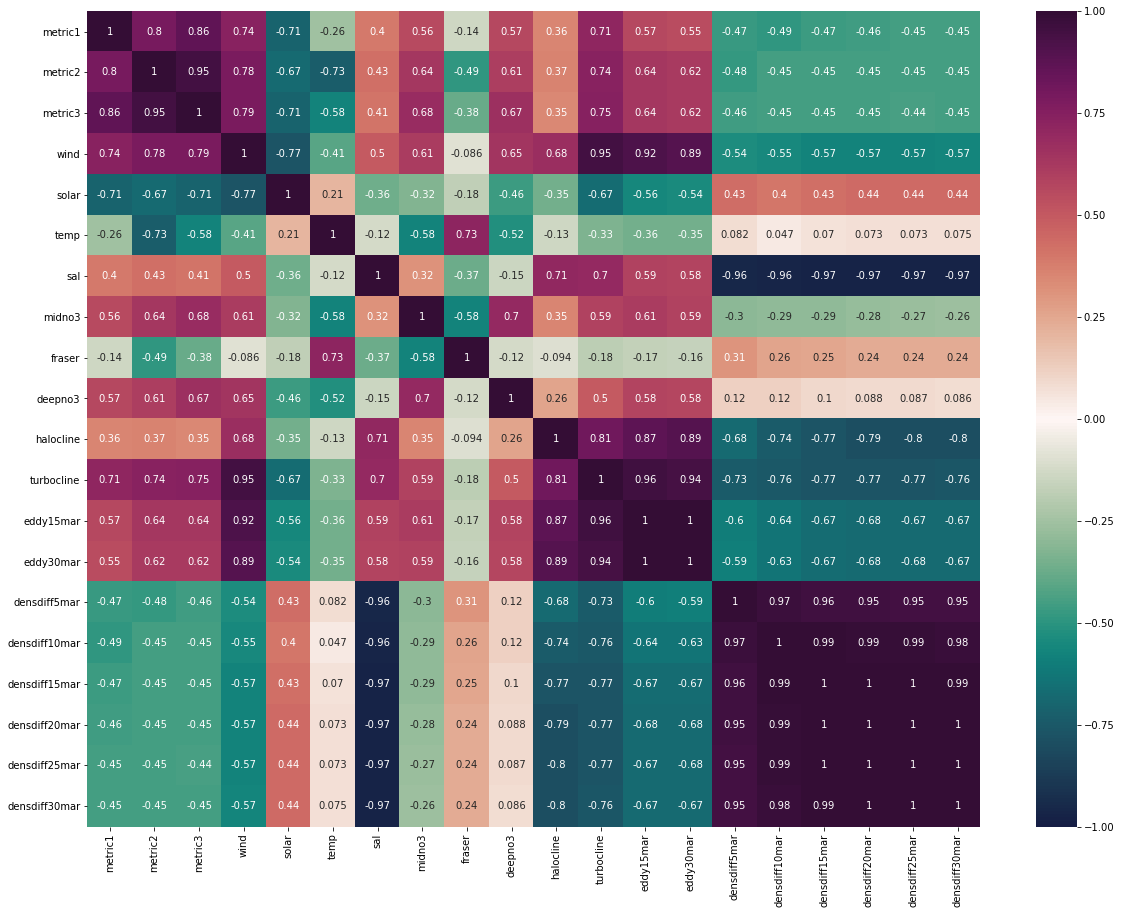

In [15]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

### Correlation plots of wind residuals

In [16]:
# Wind residual calculations for each metric
windresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday1)
for ind,y in enumerate(yearday1):
    x=windmar[ind]
    windresid1.append(y-(m*x+b))

windresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday2)
for ind,y in enumerate(yearday2):
    x=windmar[ind]
    windresid2.append(y-(m*x+b))
    
windresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(windmar,yearday3)
for ind,y in enumerate(yearday3):
    x=windmar[ind]
    windresid3.append(y-(m*x+b))

In [17]:
dfwind=pd.DataFrame({'wind':windmar,'windresid1':windresid1,'windresid2':windresid2,'windresid3':windresid3,'solar':solarmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocline':halomar})

<AxesSubplot:>

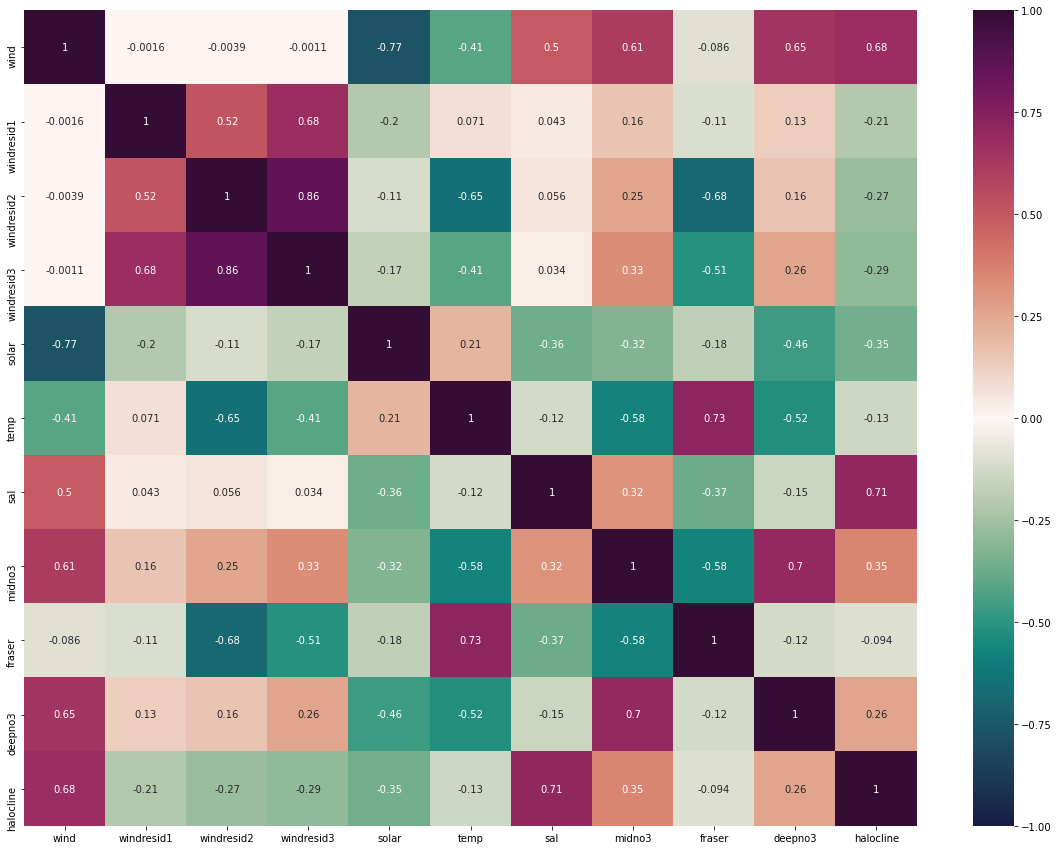

In [18]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfwind.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

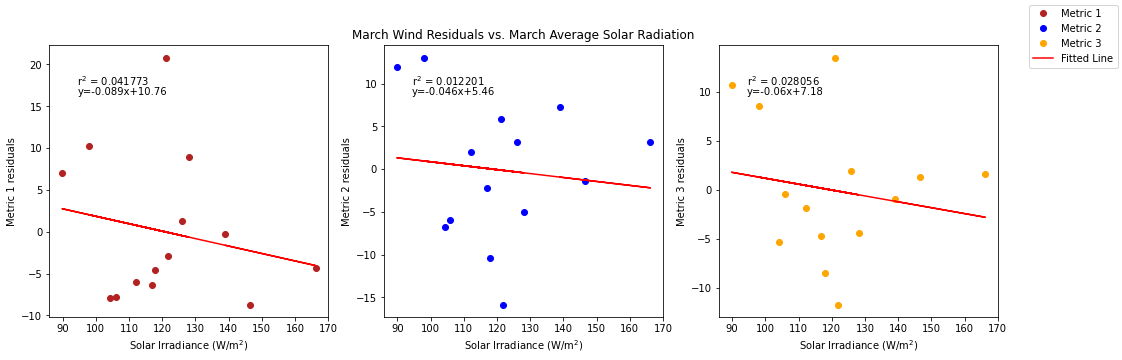

In [19]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,windresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

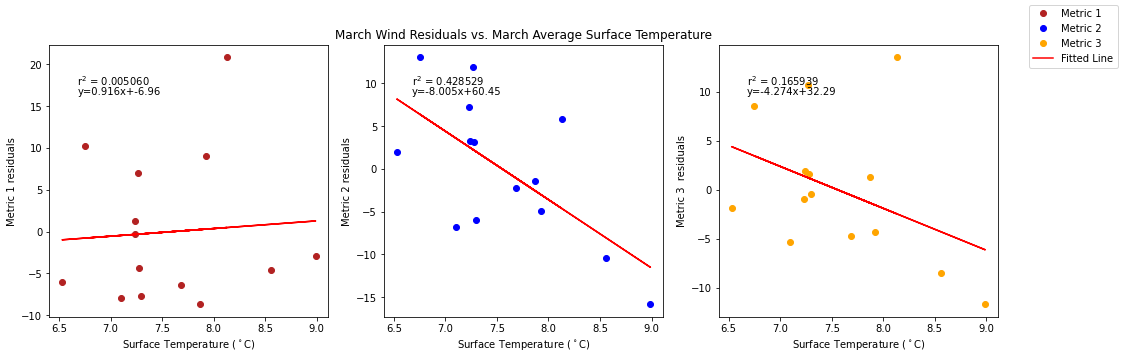

In [20]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3  residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,windresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

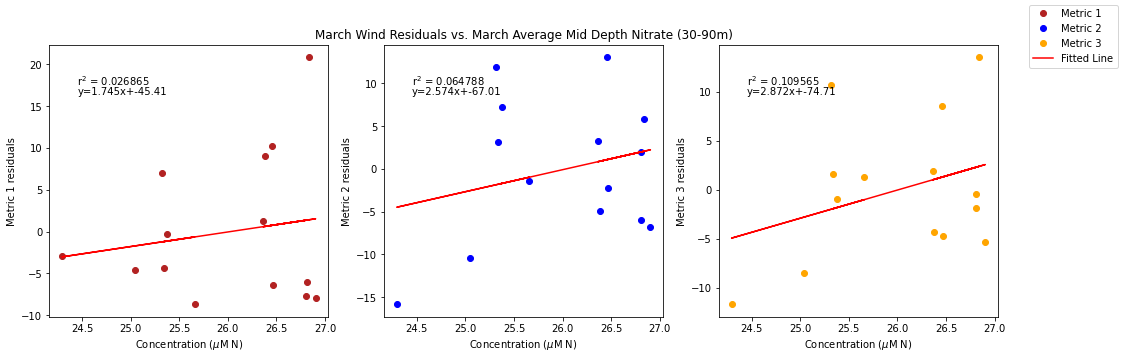

In [21]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,windresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

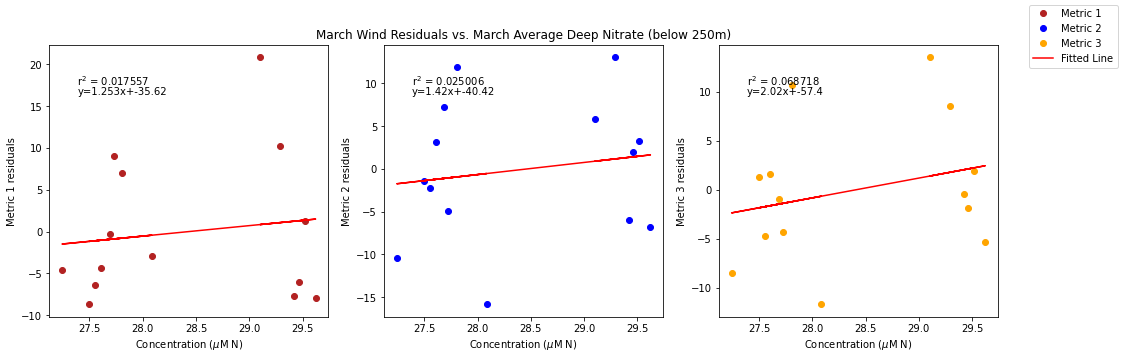

In [22]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,windresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

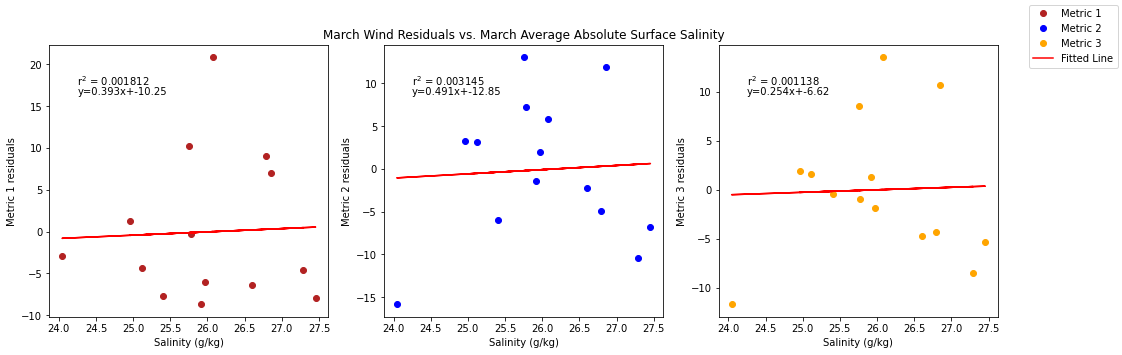

In [23]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,windresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

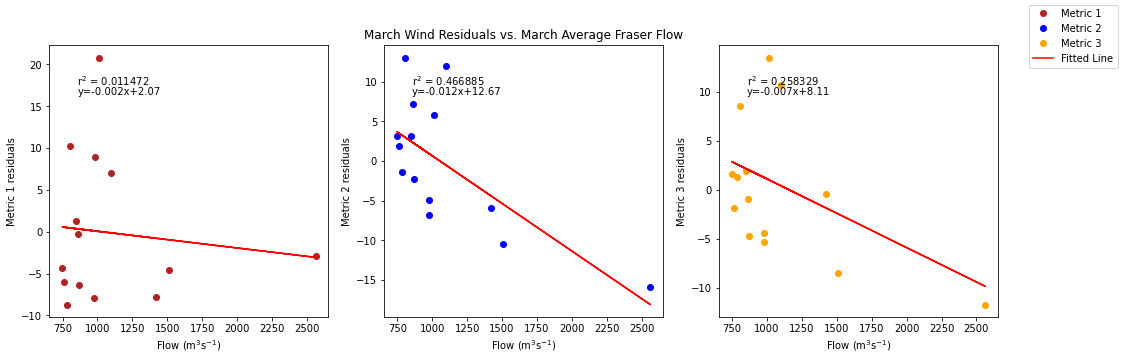

In [24]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,windresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

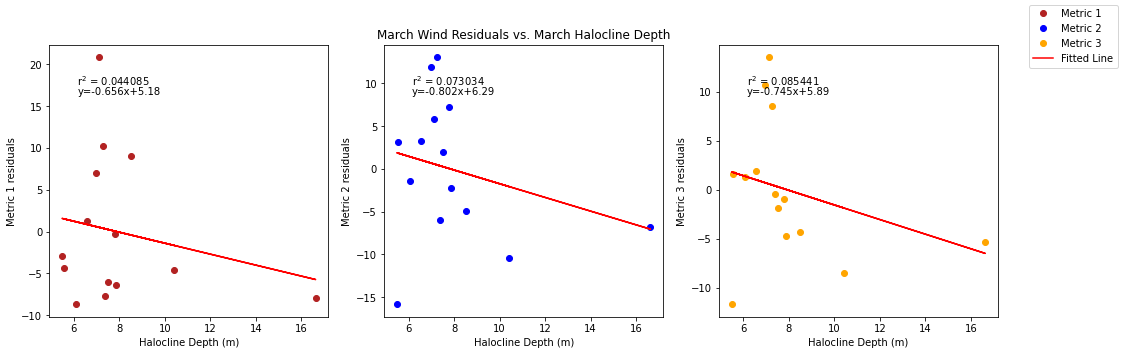

In [25]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,windresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,windresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Wind Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,windresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,windresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of solar residuals

In [26]:
#  residual calculations for each metric
solarresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday1)
for ind,y in enumerate(yearday1):
    x=solarmar[ind]
    solarresid1.append(y-(m*x+b))

solarresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday2)
for ind,y in enumerate(yearday2):
    x=solarmar[ind]
    solarresid2.append(y-(m*x+b))
    
solarresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(solarmar,yearday3)
for ind,y in enumerate(yearday3):
    x=solarmar[ind]
    solarresid3.append(y-(m*x+b))

In [27]:
dfsolar=pd.DataFrame({'solar':solarmar,'solarresid1':solarresid1,'solarresid2':solarresid2,'solarresid3':solarresid3,'wind':windmar,
                  'temp':tempmar,'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

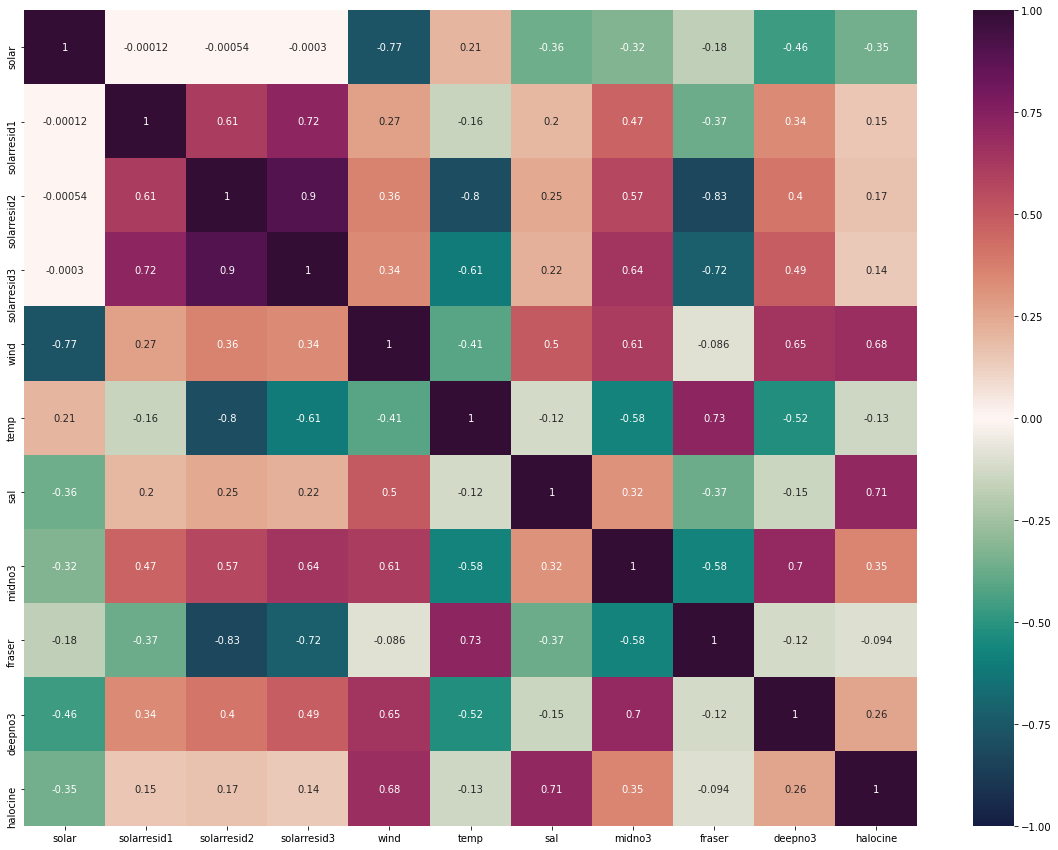

In [28]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfsolar.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

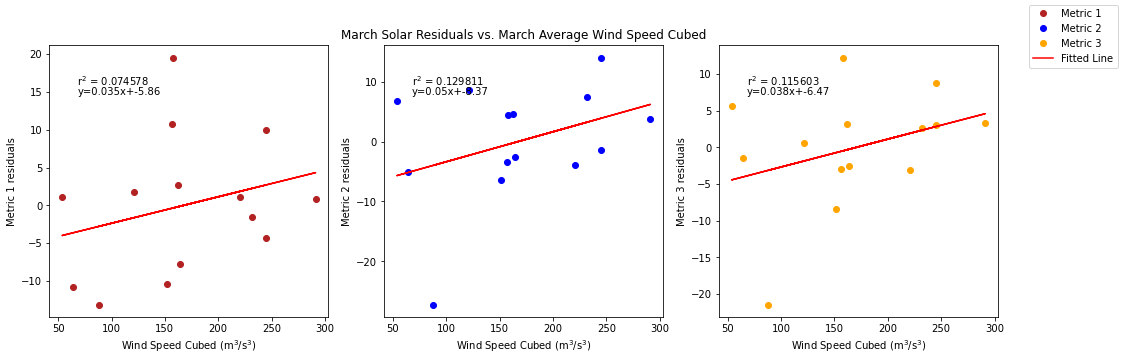

In [29]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,solarresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

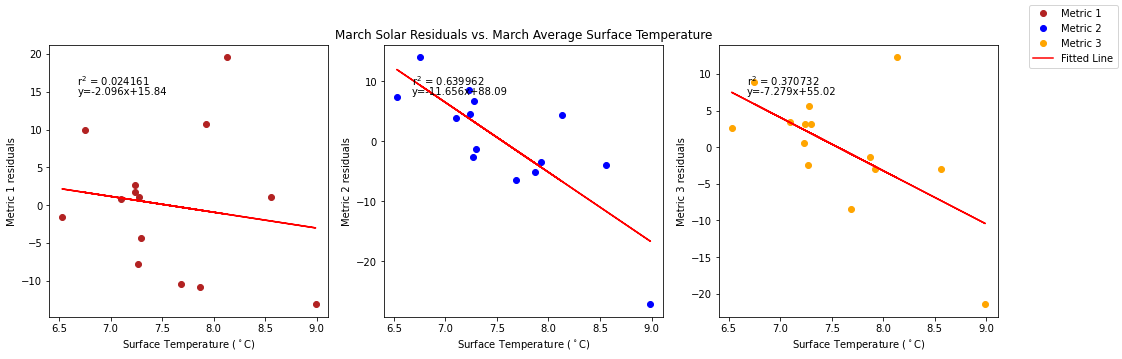

In [30]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,solarresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

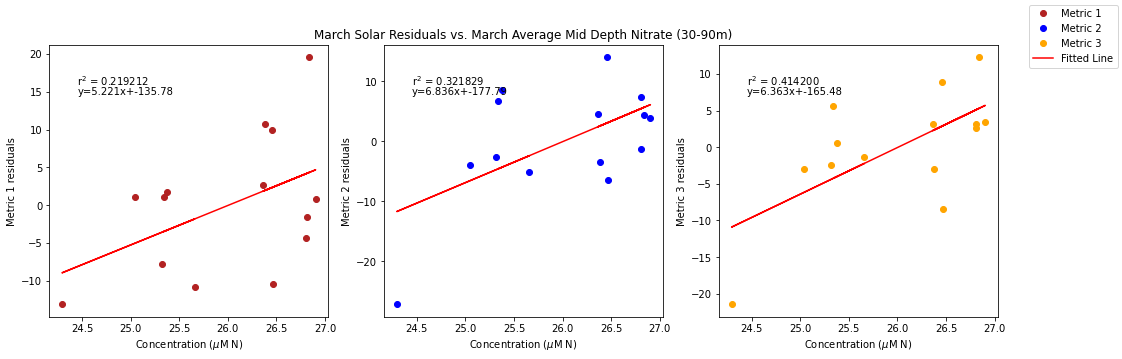

In [31]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,solarresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

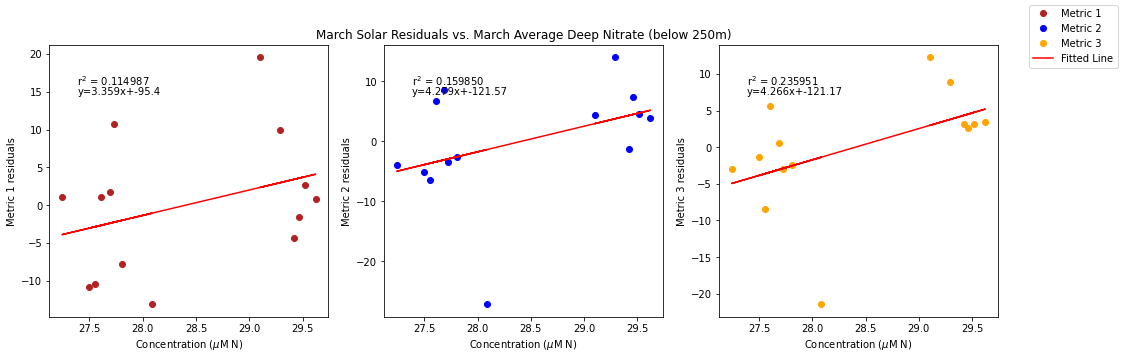

In [32]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,solarresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

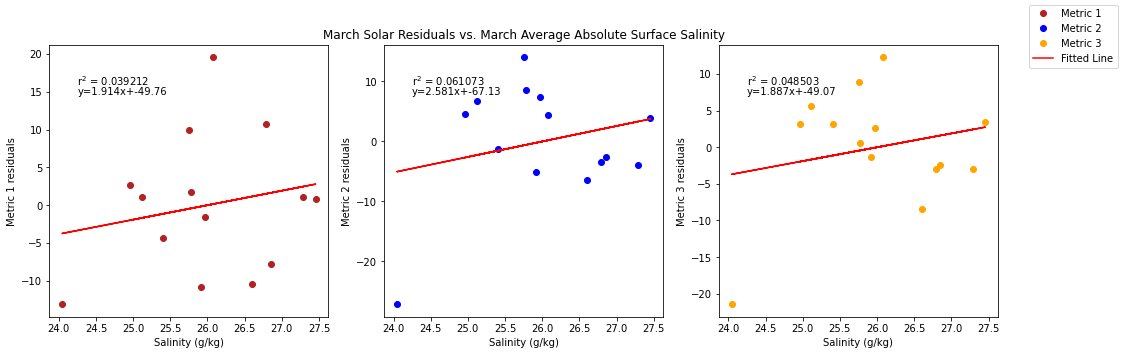

In [33]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,solarresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

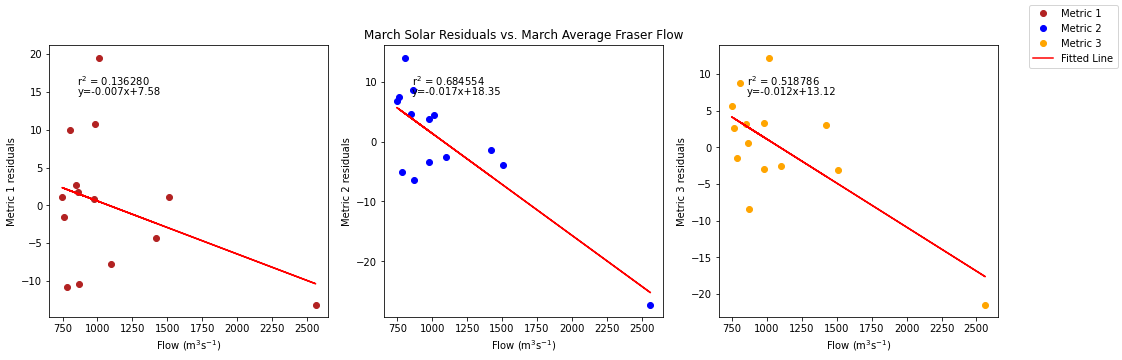

In [34]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,solarresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

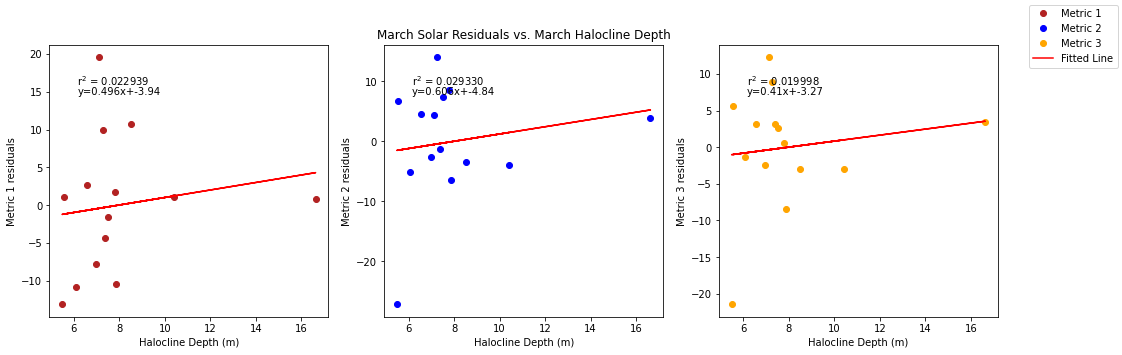

In [35]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,solarresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,solarresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Solar Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,solarresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,solarresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of temperature residuals

In [36]:
#  residual calculations for each metric
tempresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday1)
for ind,y in enumerate(yearday1):
    x=tempmar[ind]
    tempresid1.append(y-(m*x+b))

tempresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday2)
for ind,y in enumerate(yearday2):
    x=tempmar[ind]
    tempresid2.append(y-(m*x+b))
    
tempresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(tempmar,yearday3)
for ind,y in enumerate(yearday3):
    x=tempmar[ind]
    tempresid3.append(y-(m*x+b))

In [37]:
dftemp=pd.DataFrame({'temp':tempmar,'tempresid1':tempresid1,'tempresid2':tempresid2,'tempresid3':tempresid3,'wind':windmar,'solar':solarmar,
                  'sal':salmar,'midno3':midno3mar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

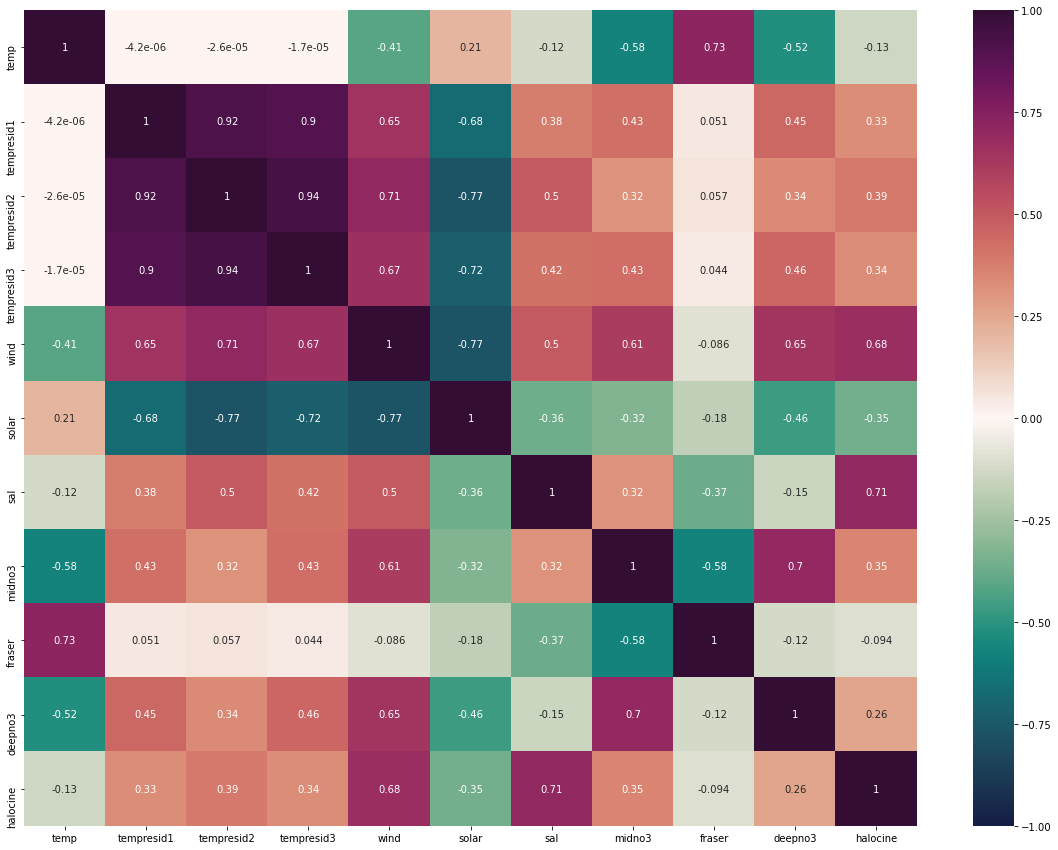

In [38]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dftemp.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

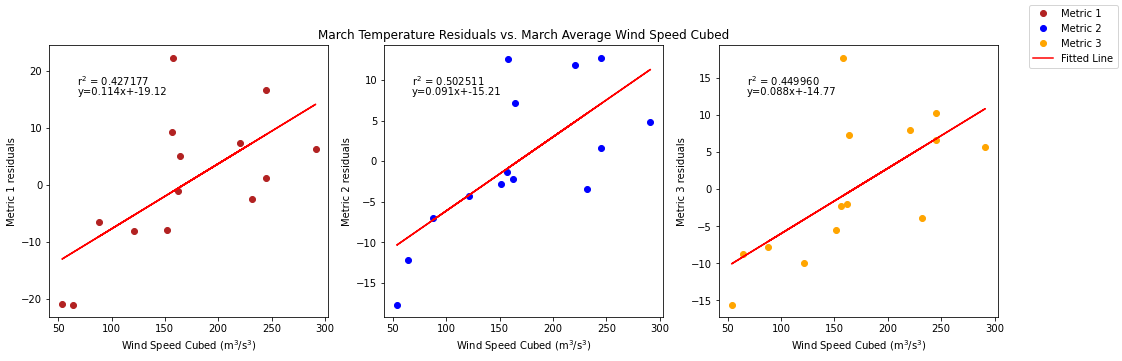

In [39]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,tempresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

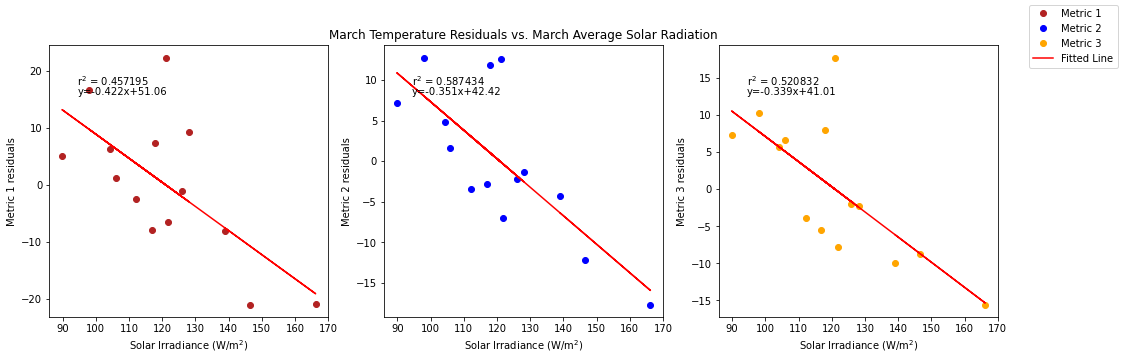

In [40]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,tempresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

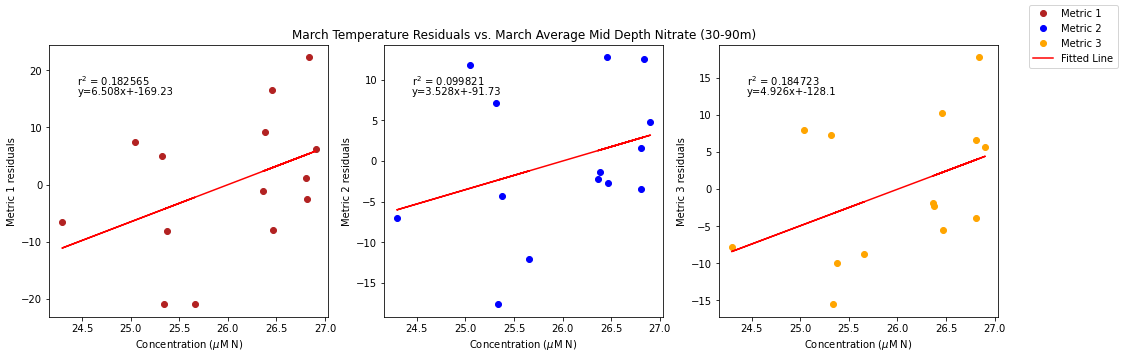

In [41]:
# ---------- Mid NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Mid Depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,tempresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

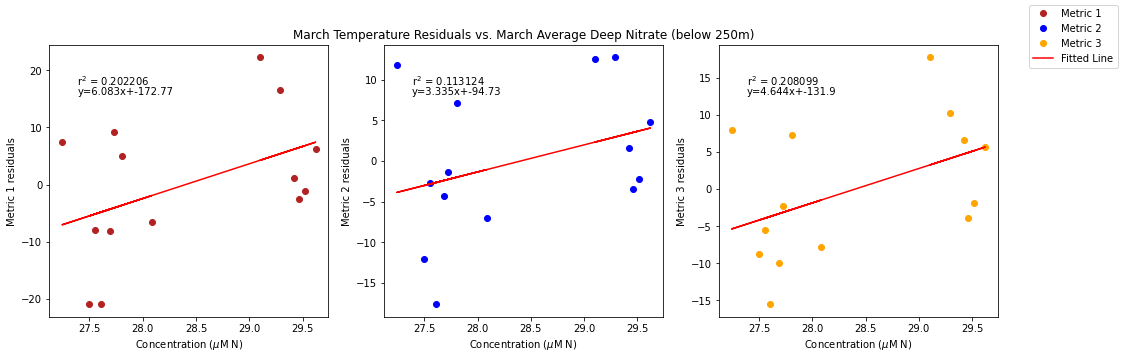

In [42]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,tempresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

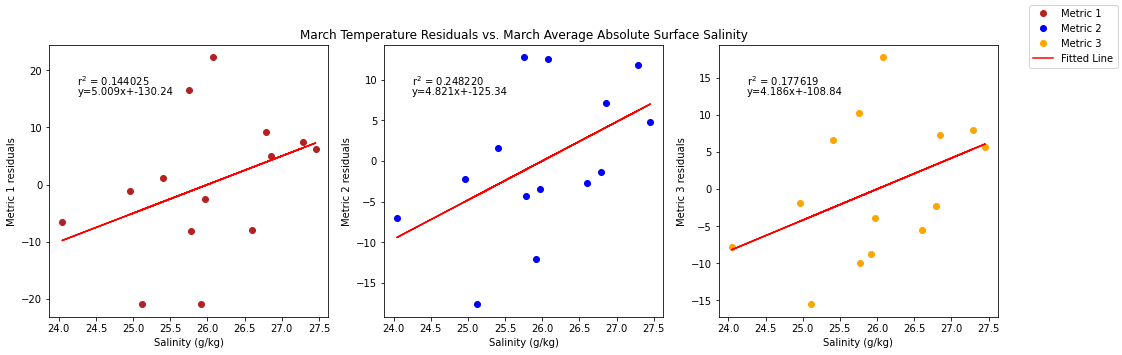

In [43]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,tempresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

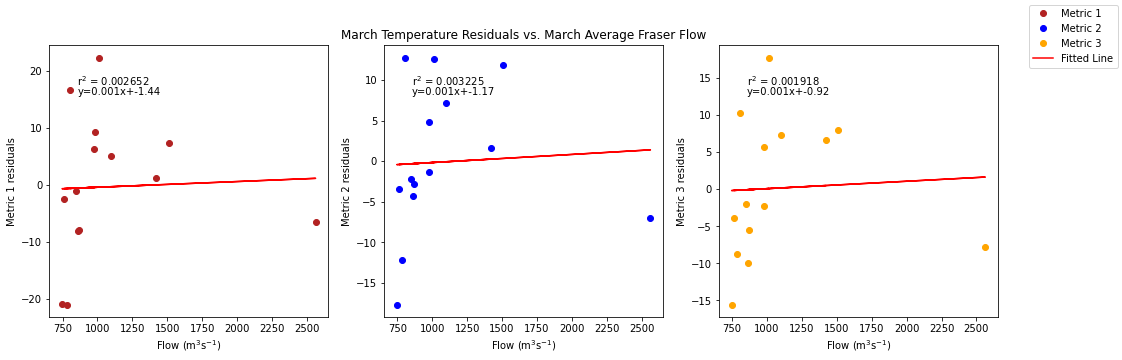

In [44]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,tempresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

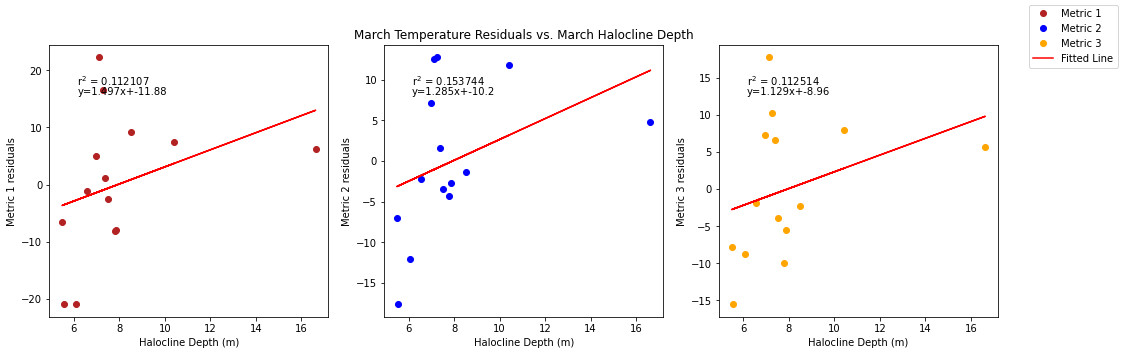

In [45]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,tempresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,tempresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Temperature Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,tempresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,tempresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of mid NO3 residuals

In [46]:
#  residual calculations for each metric
midno3resid1=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday1)
for ind,y in enumerate(yearday1):
    x=midno3mar[ind]
    midno3resid1.append(y-(m*x+b))

midno3resid2=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday2)
for ind,y in enumerate(yearday2):
    x=midno3mar[ind]
    midno3resid2.append(y-(m*x+b))
    
midno3resid3=list()
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,yearday3)
for ind,y in enumerate(yearday3):
    x=midno3mar[ind]
    midno3resid3.append(y-(m*x+b))

In [47]:
dfmidno3=pd.DataFrame({'midno3':midno3mar,'midno3resid1':midno3resid1,'midno3resid2':midno3resid2,'midno3resid3':midno3resid3,'wind':windmar,'solar':solarmar,
                       'temp':tempmar,'sal':salmar,'fraser':frasermar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

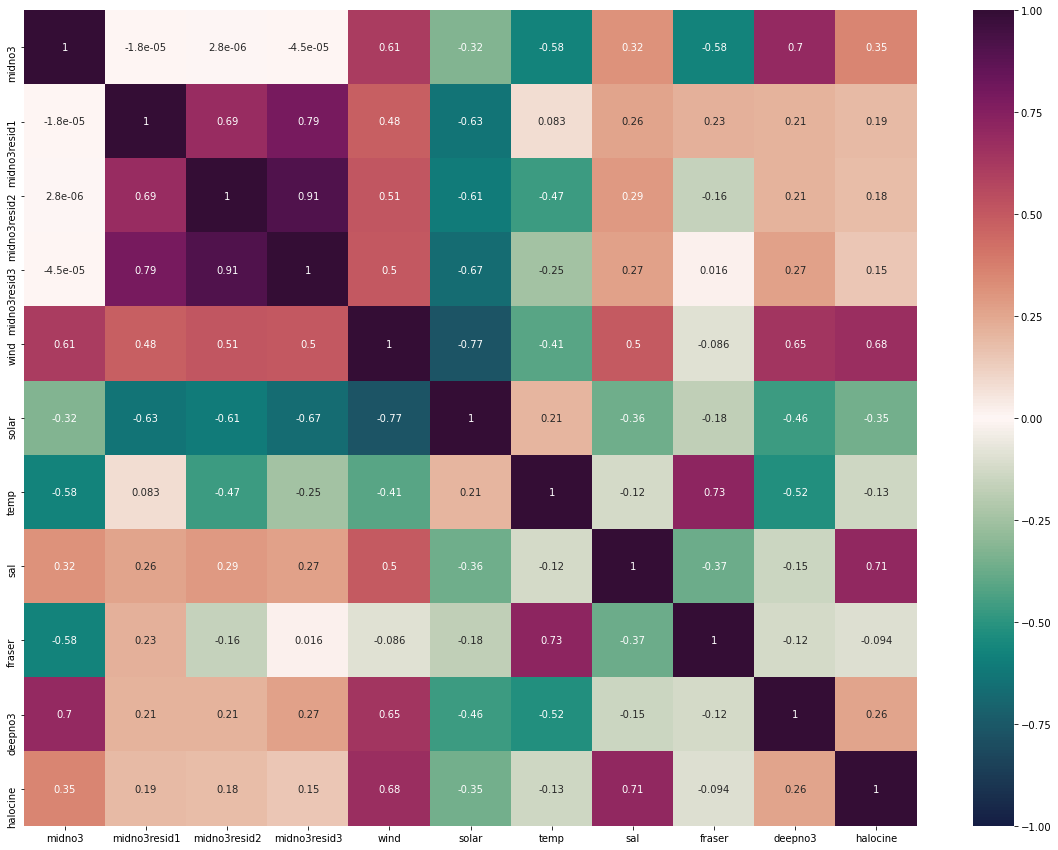

In [48]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfmidno3.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

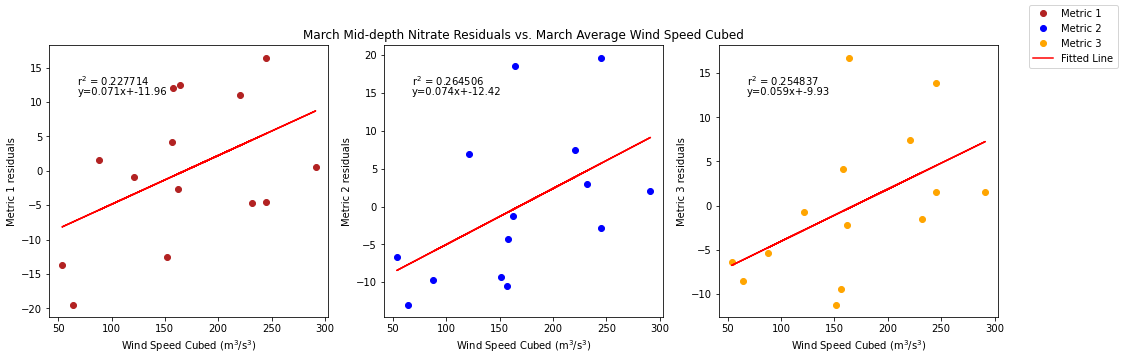

In [49]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,midno3resid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

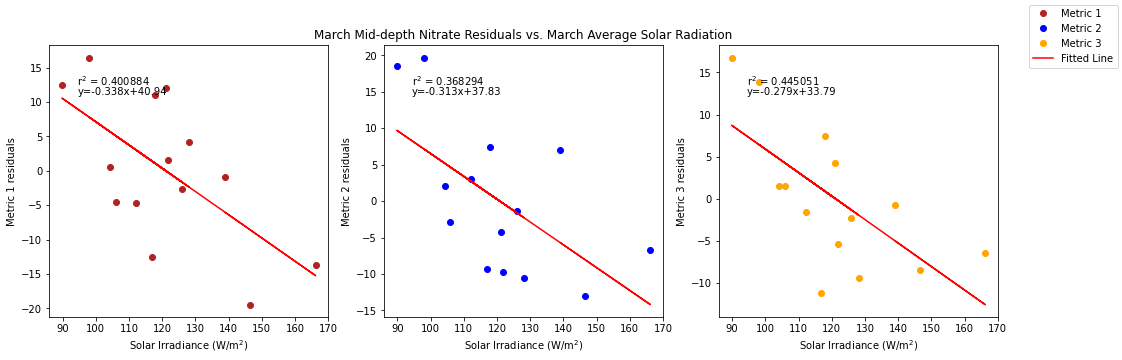

In [50]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,midno3resid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

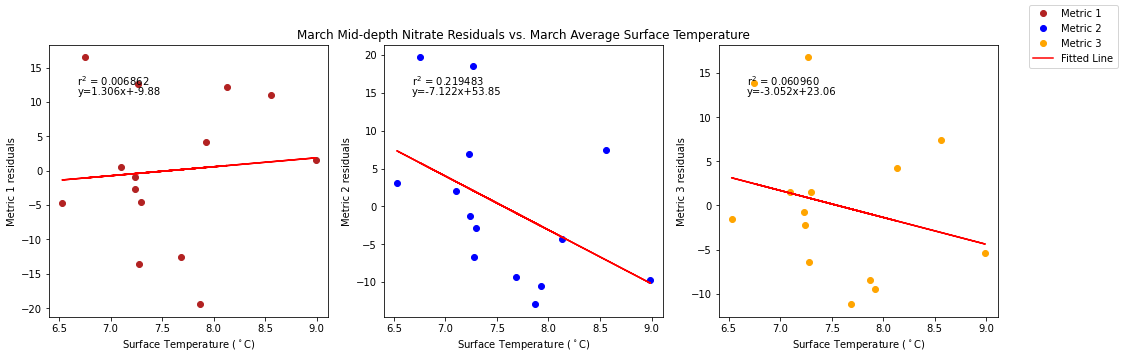

In [51]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,midno3resid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

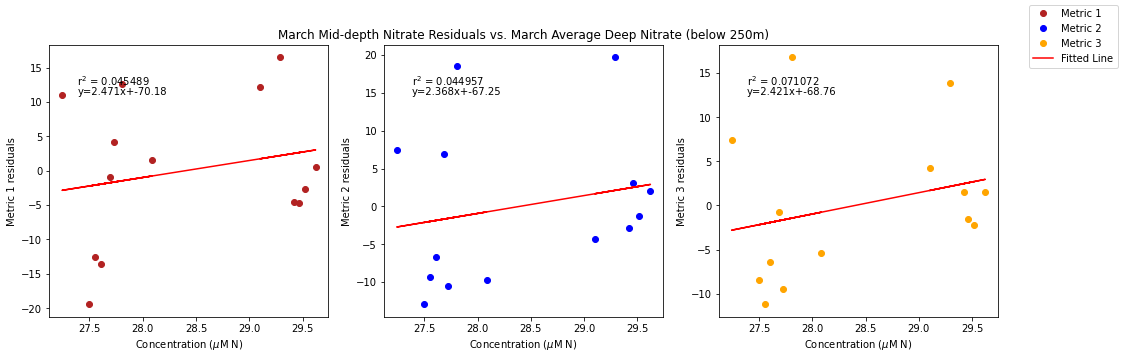

In [52]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,midno3resid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

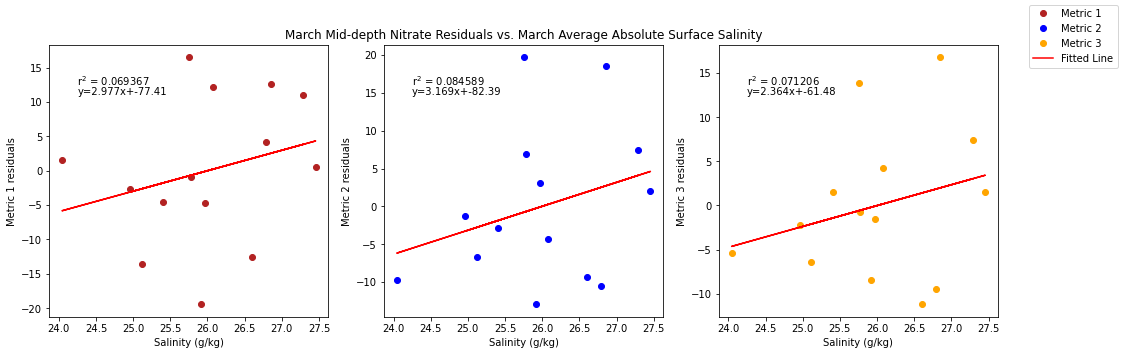

In [53]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,midno3resid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

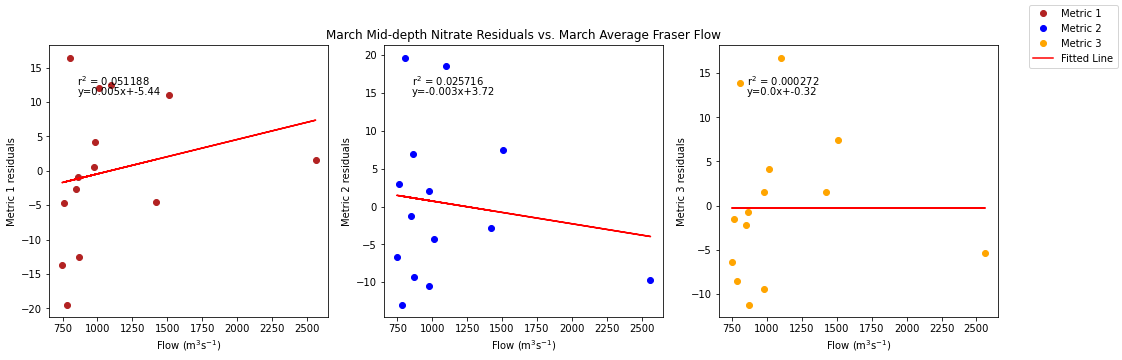

In [54]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,midno3resid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

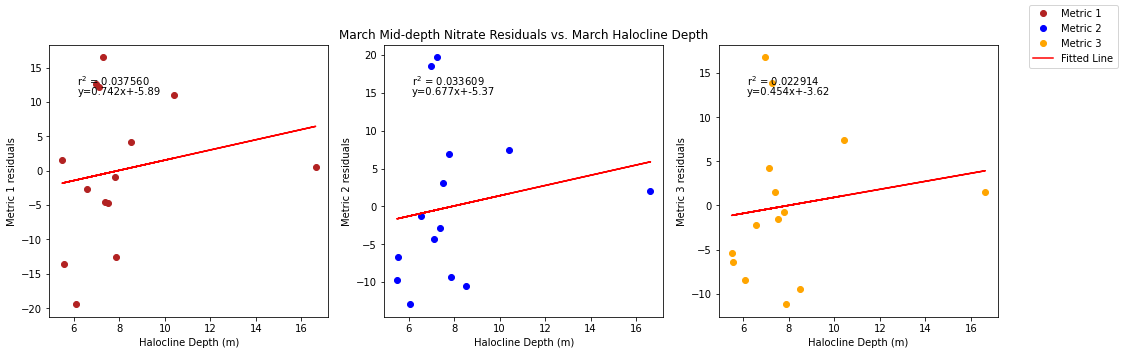

In [55]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,midno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,midno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Mid-depth Nitrate Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,midno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,midno3resid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of deep NO3 residuals

In [56]:
#  residual calculations for each metric
deepno3resid1=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday1)
for ind,y in enumerate(yearday1):
    x=deepno3mar[ind]
    deepno3resid1.append(y-(m*x+b))

deepno3resid2=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday2)
for ind,y in enumerate(yearday2):
    x=deepno3mar[ind]
    deepno3resid2.append(y-(m*x+b))
    
deepno3resid3=list()
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,yearday3)
for ind,y in enumerate(yearday3):
    x=deepno3mar[ind]
    deepno3resid3.append(y-(m*x+b))

In [57]:
dfdeepno3=pd.DataFrame({'deepno3':deepno3mar,'deepno3resid1':deepno3resid1,'deepno3resid2':deepno3resid2,'deepno3resid3':deepno3resid3,'wind':windmar,'solar':solarmar,
                        'temp':tempmar,'sal':salmar,'fraser':frasermar,'midno3':midno3mar,'halocine':halomar})

<AxesSubplot:>

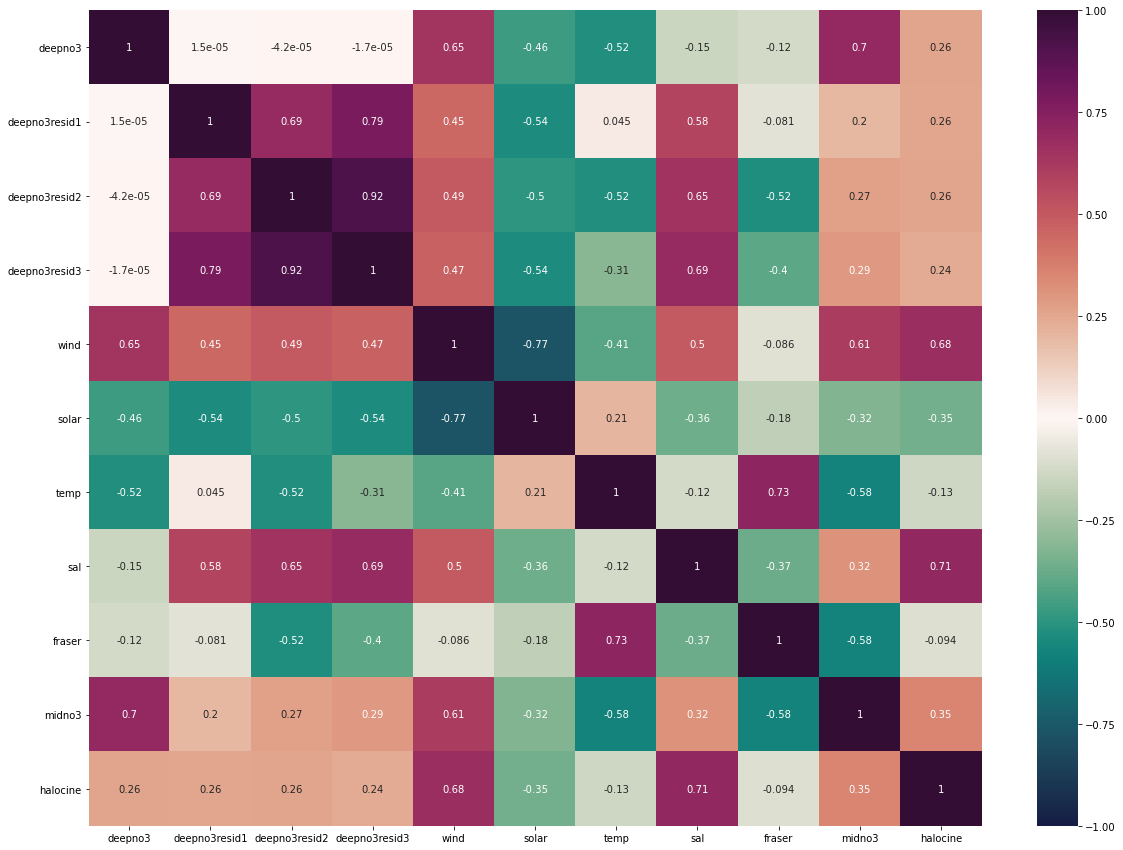

In [58]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfdeepno3.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

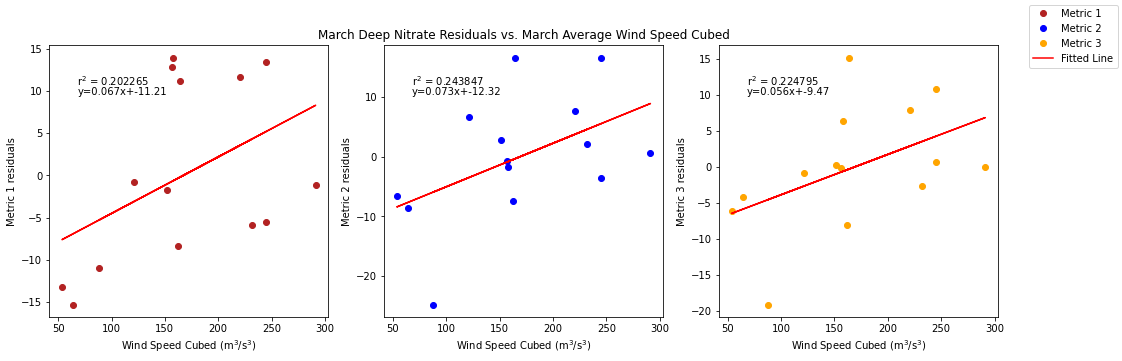

In [59]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,deepno3resid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

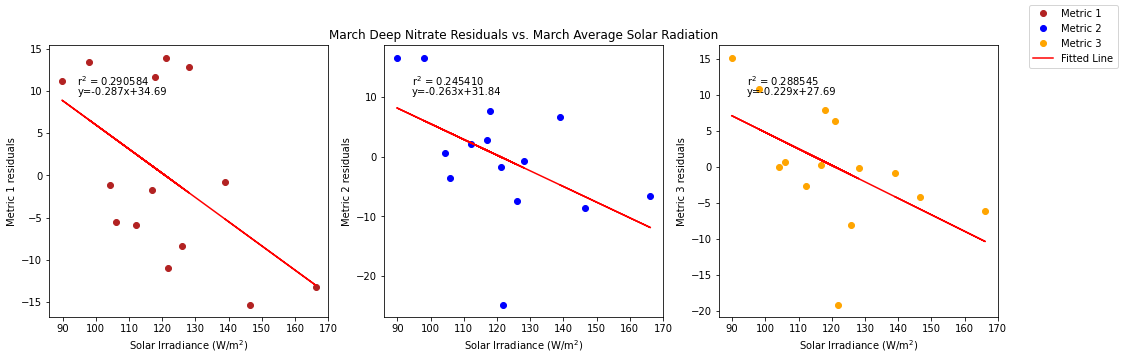

In [60]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,deepno3resid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

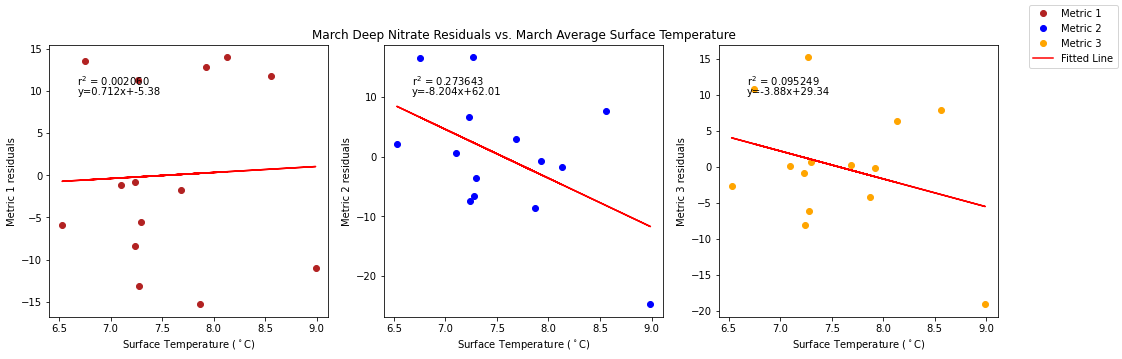

In [61]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,deepno3resid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

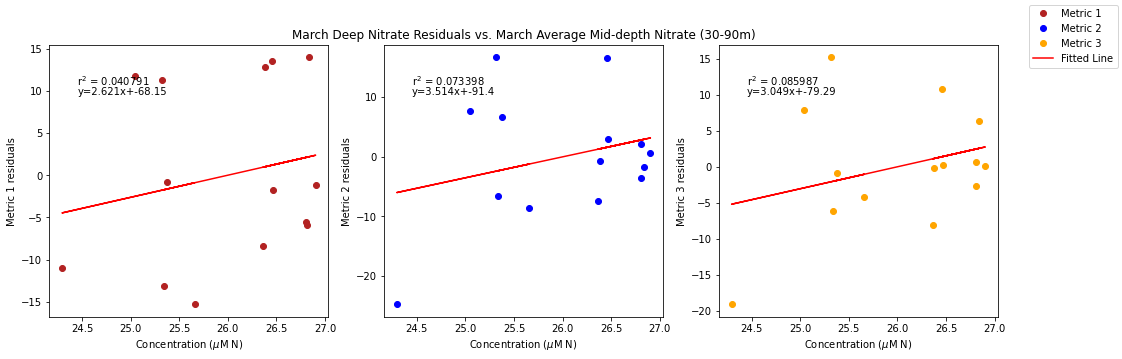

In [62]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,deepno3resid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

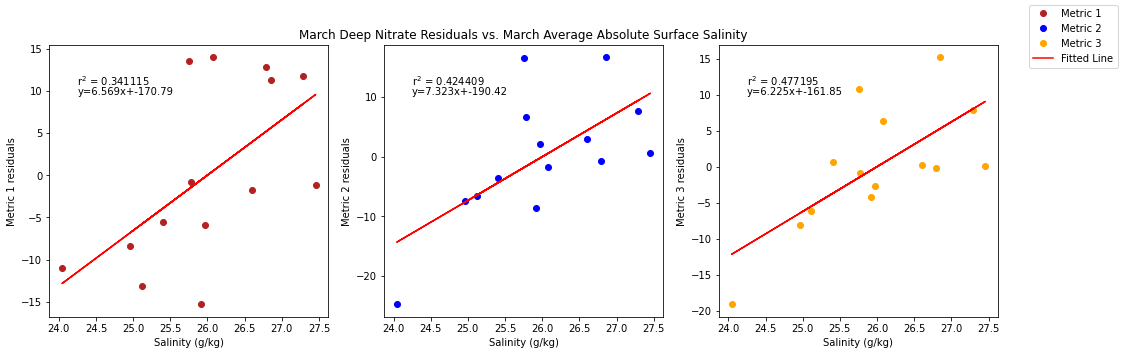

In [63]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,deepno3resid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

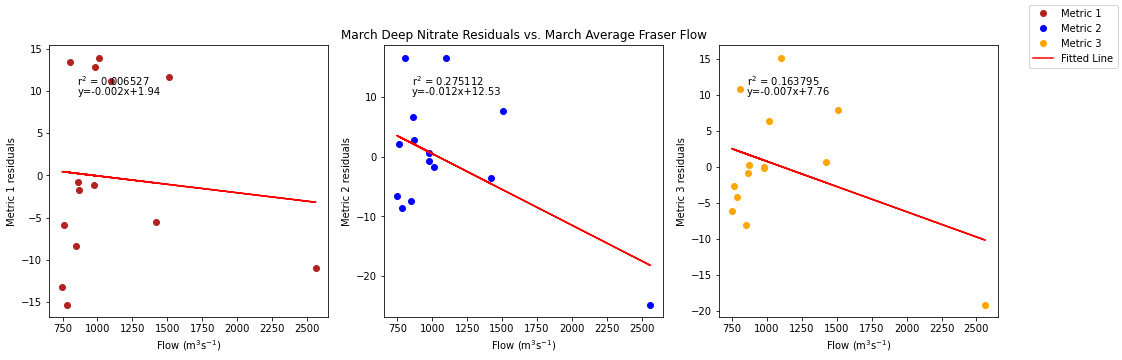

In [64]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,deepno3resid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

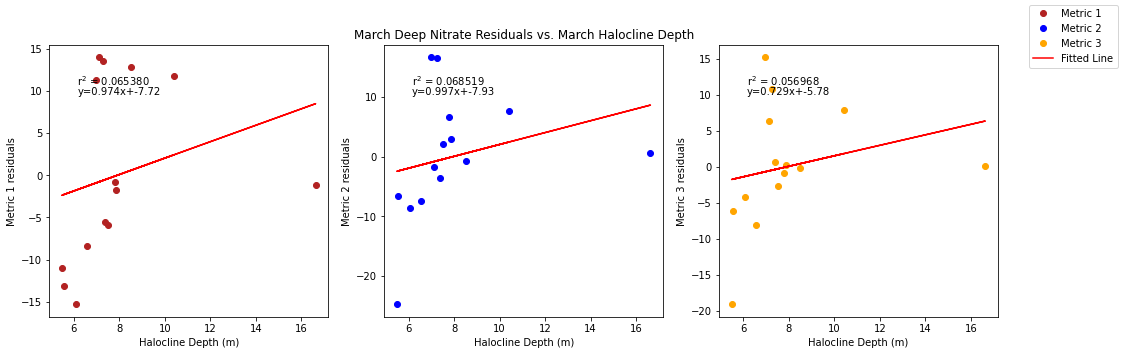

In [65]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,deepno3resid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,deepno3resid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Deep Nitrate Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,deepno3resid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,deepno3resid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Salinity residuals

In [66]:
#  residual calculations for each metric
salresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday1)
for ind,y in enumerate(yearday1):
    x=salmar[ind]
    salresid1.append(y-(m*x+b))

salresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday2)
for ind,y in enumerate(yearday2):
    x=salmar[ind]
    salresid2.append(y-(m*x+b))
    
salresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(salmar,yearday3)
for ind,y in enumerate(yearday3):
    x=salmar[ind]
    salresid3.append(y-(m*x+b))

In [67]:
dfsal=pd.DataFrame({'sal':salmar,'salresid1':salresid1,'salresid2':salresid2,'salresid3':salresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'fraser':frasermar,'midno3':midno3mar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

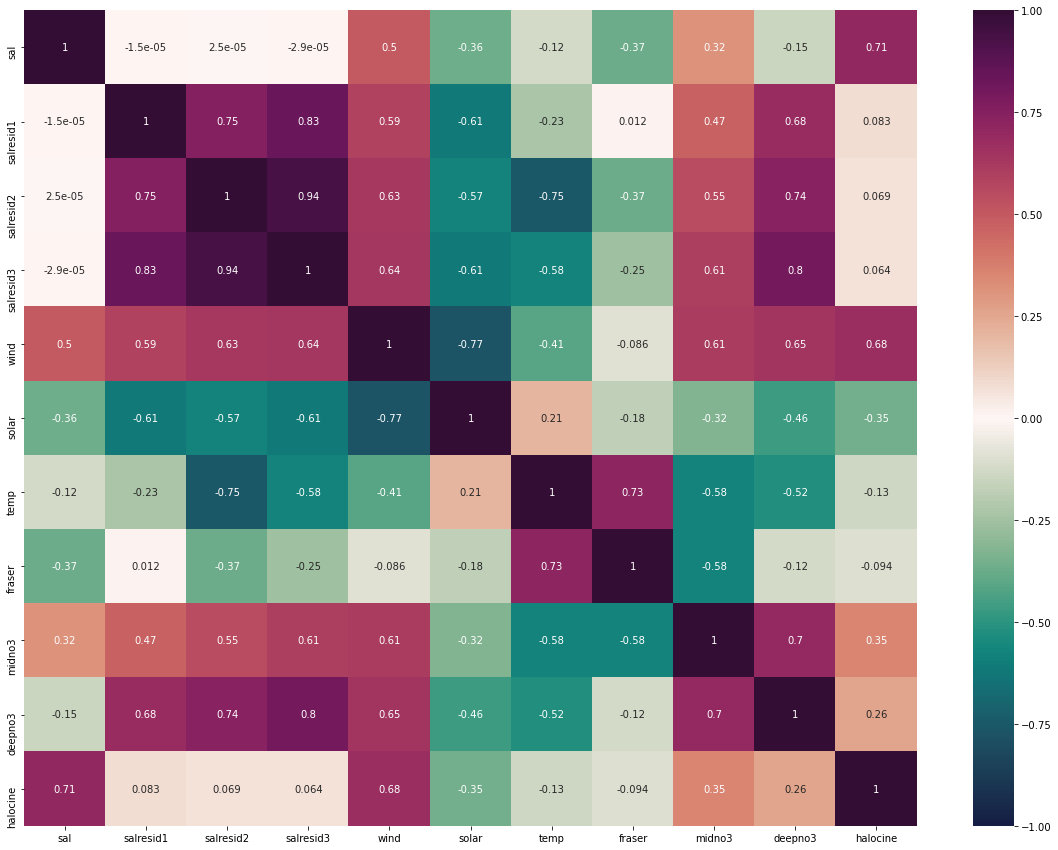

In [68]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfsal.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

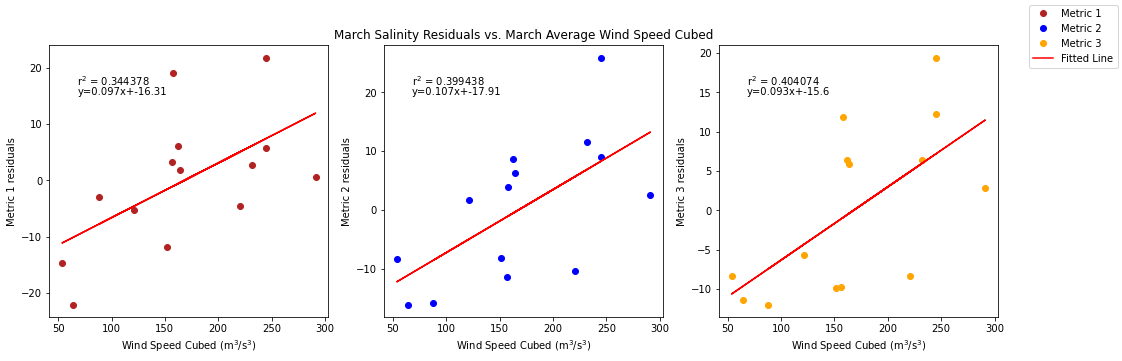

In [69]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,salresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

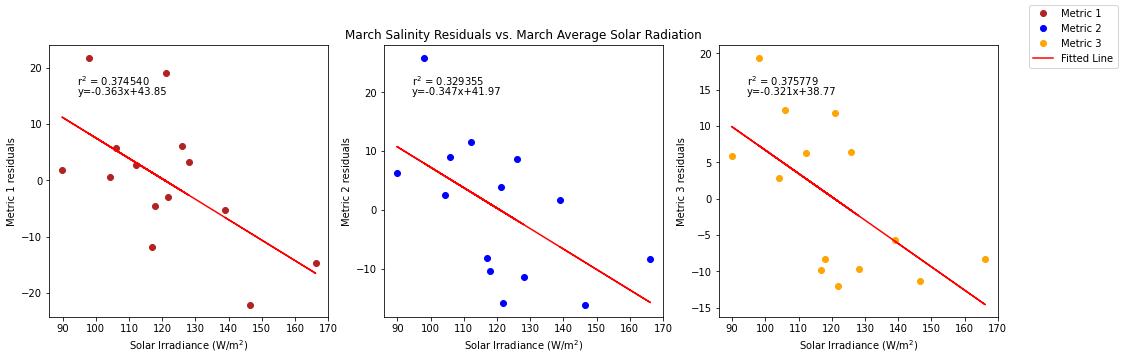

In [70]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,salresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

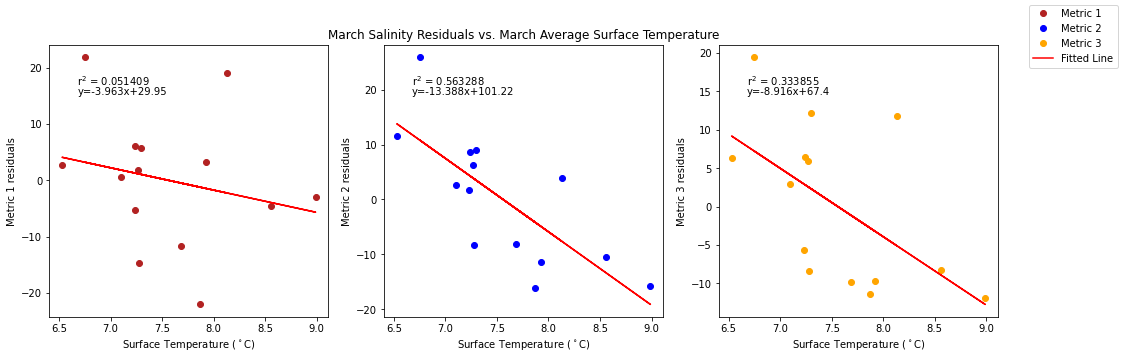

In [71]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,salresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

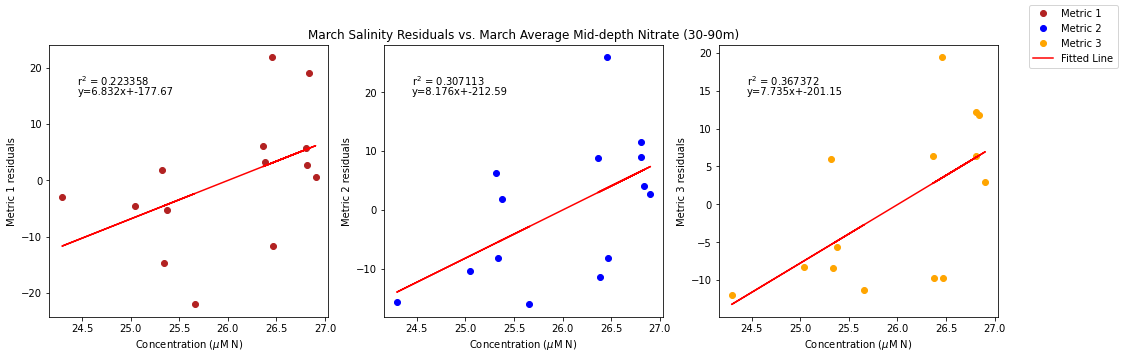

In [72]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,salresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

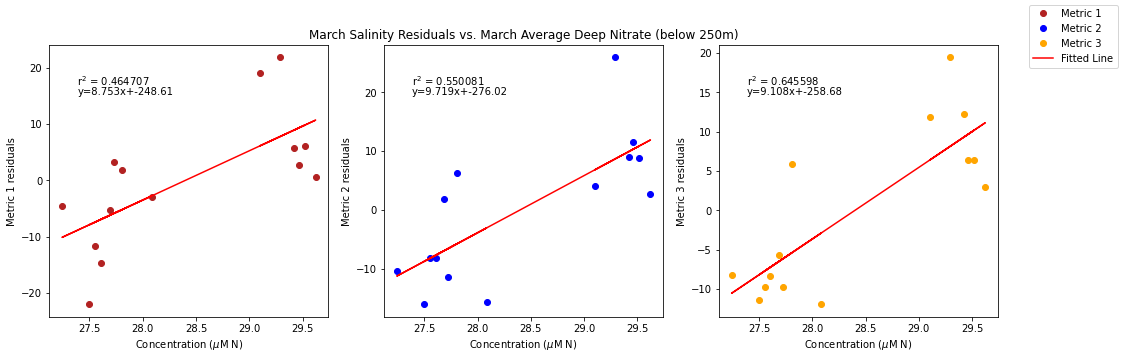

In [73]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,salresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

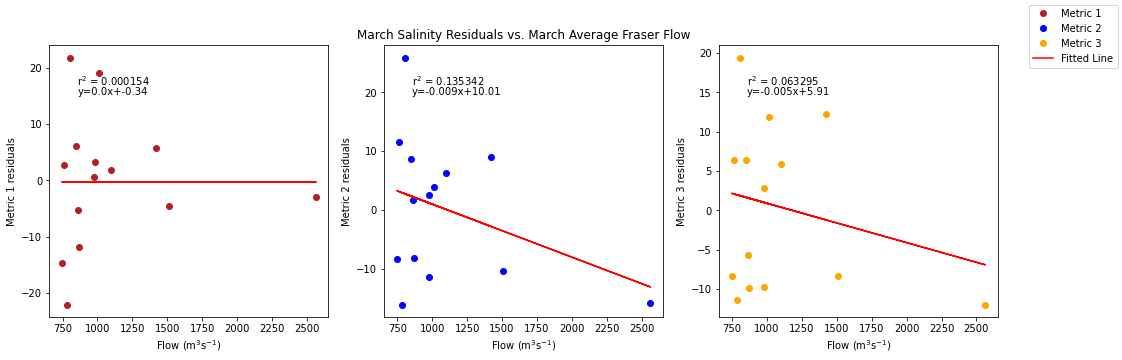

In [74]:
# ---------- Fraser ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(frasermar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid1)
ax4[0].plot(frasermar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(frasermar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Average Fraser Flow')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid2)
ax4[1].plot(frasermar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(frasermar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Flow (m$^3$s$^{-1}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(frasermar,salresid3)
ax4[2].plot(frasermar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

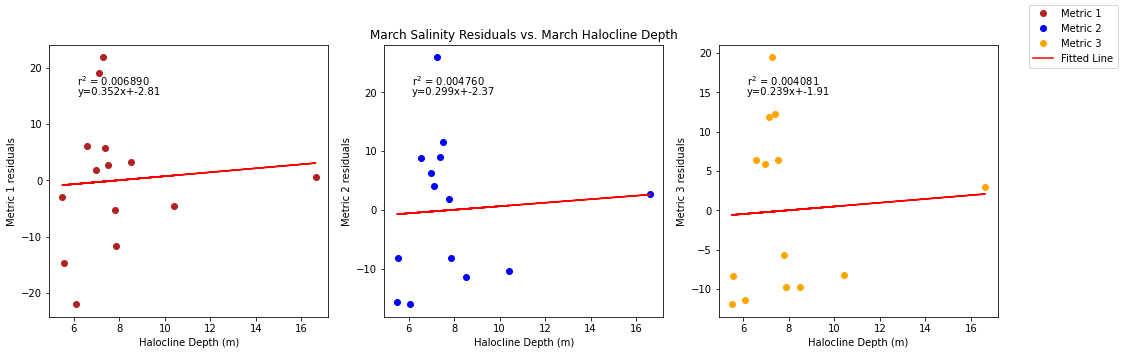

In [75]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,salresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,salresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,salresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,salresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Fraser residuals

In [76]:
#  residual calculations for each metric
fraserresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday1)
for ind,y in enumerate(yearday1):
    x=frasermar[ind]
    fraserresid1.append(y-(m*x+b))

fraserresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday2)
for ind,y in enumerate(yearday2):
    x=frasermar[ind]
    fraserresid2.append(y-(m*x+b))
    
fraserresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(frasermar,yearday3)
for ind,y in enumerate(yearday3):
    x=frasermar[ind]
    fraserresid3.append(y-(m*x+b))

In [77]:
dffraser=pd.DataFrame({'fraser':frasermar,'fraserresid1':fraserresid1,'fraserresid2':fraserresid2,'fraserresid3':fraserresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'midno3':midno3mar,'deepno3':deepno3mar,'halocine':halomar})

<AxesSubplot:>

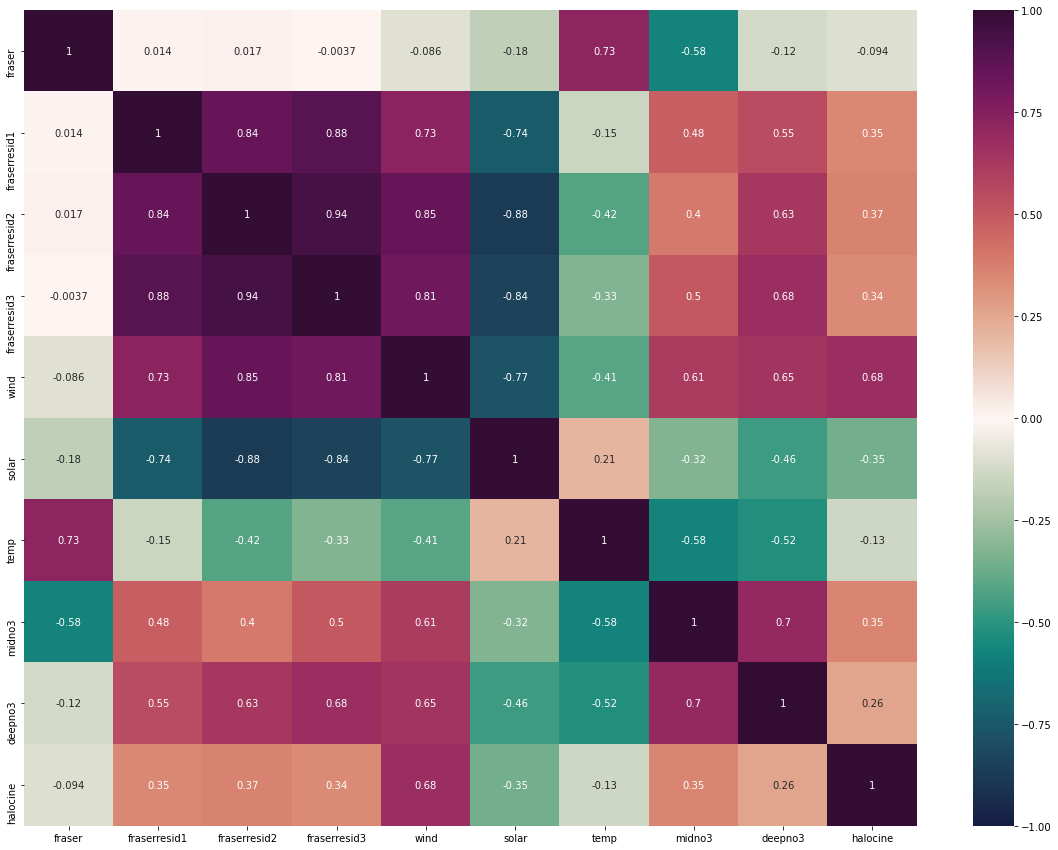

In [78]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dffraser.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

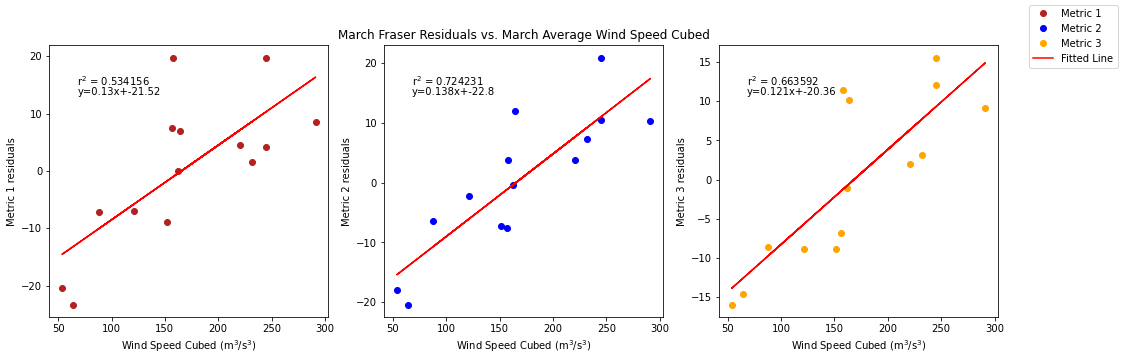

In [79]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,fraserresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

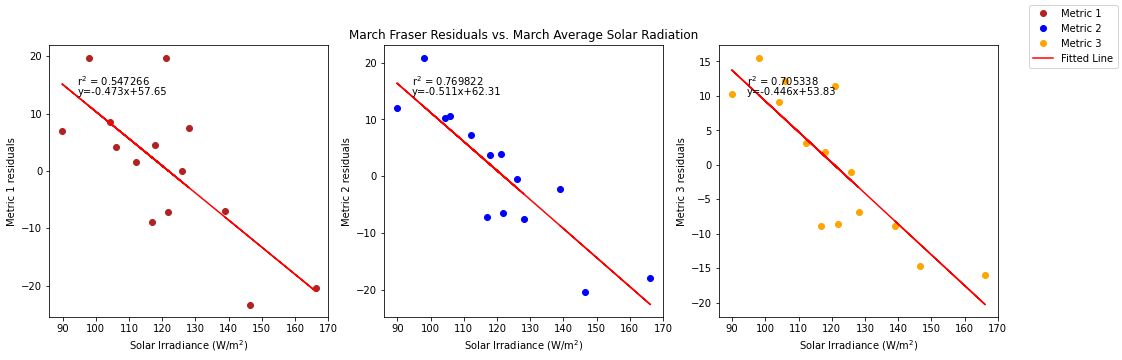

In [80]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar, fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,fraserresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

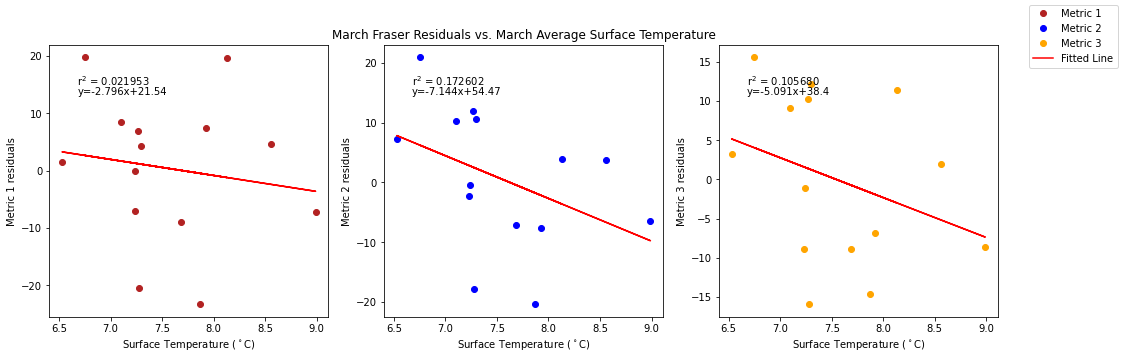

In [81]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,fraserresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

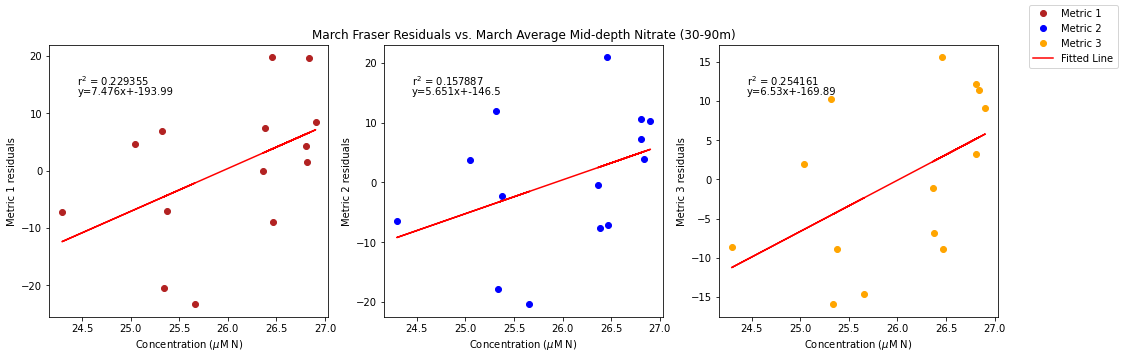

In [82]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,fraserresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

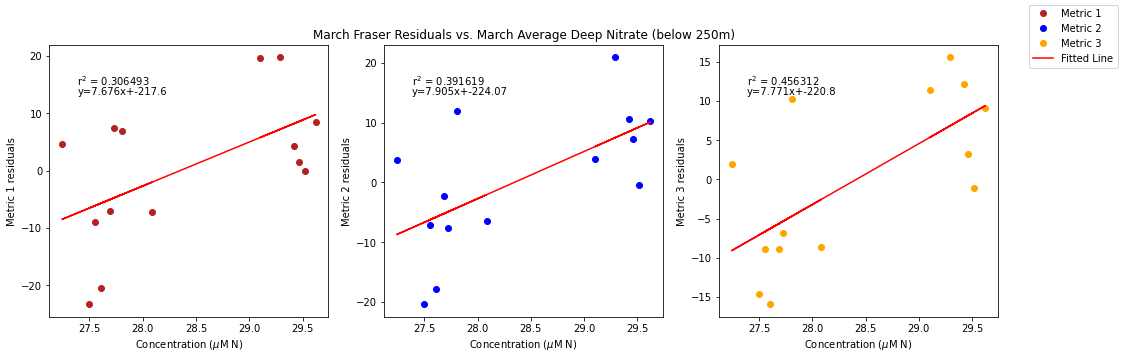

In [83]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,fraserresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

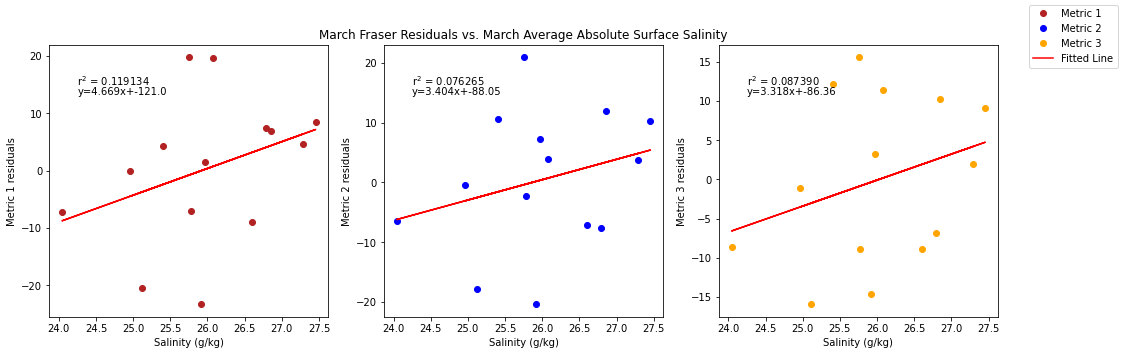

In [84]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Fraser Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,fraserresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

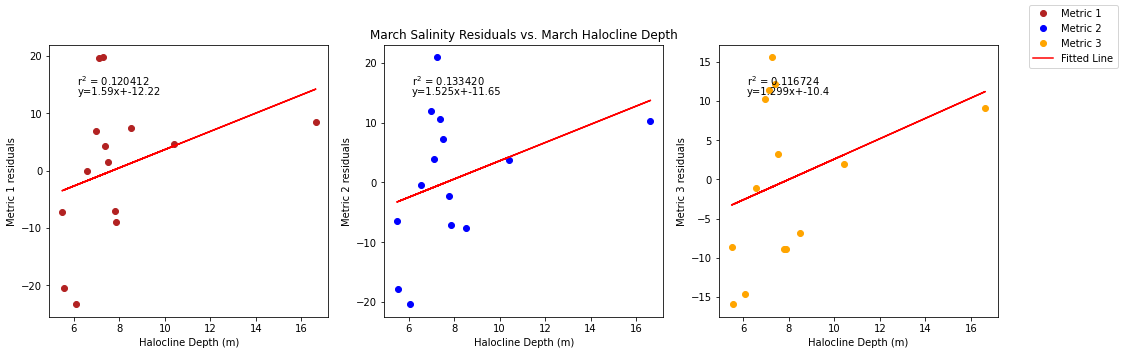

In [85]:
# ---------- Halocline ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(halomar,fraserresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Halocline Depth (m)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid1)
ax4[0].plot(halomar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(halomar,fraserresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Halocline Depth (m)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Salinity Residuals vs. March Halocline Depth')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid2)
ax4[1].plot(halomar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(halomar,fraserresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Halocline Depth (m)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(halomar,fraserresid3)
ax4[2].plot(halomar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Correlation plots of Halocline residuals

In [86]:
#  residual calculations for each metric
haloresid1=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday1)
for ind,y in enumerate(yearday1):
    x=halomar[ind]
    haloresid1.append(y-(m*x+b))

haloresid2=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday2)
for ind,y in enumerate(yearday2):
    x=halomar[ind]
    haloresid2.append(y-(m*x+b))
    
haloresid3=list()
y,r2,m,b=bloomdrivers.reg_r2(halomar,yearday3)
for ind,y in enumerate(yearday3):
    x=halomar[ind]
    haloresid3.append(y-(m*x+b))

In [87]:
dfhalo=pd.DataFrame({'halocine':halomar,'haloresid1':haloresid1,'haloresid2':haloresid2,'haloresid3':haloresid3,'wind':windmar,'solar':solarmar,
                    'temp':tempmar,'fraser':frasermar,'midno3':midno3mar,'deepno3':deepno3mar})

<AxesSubplot:>

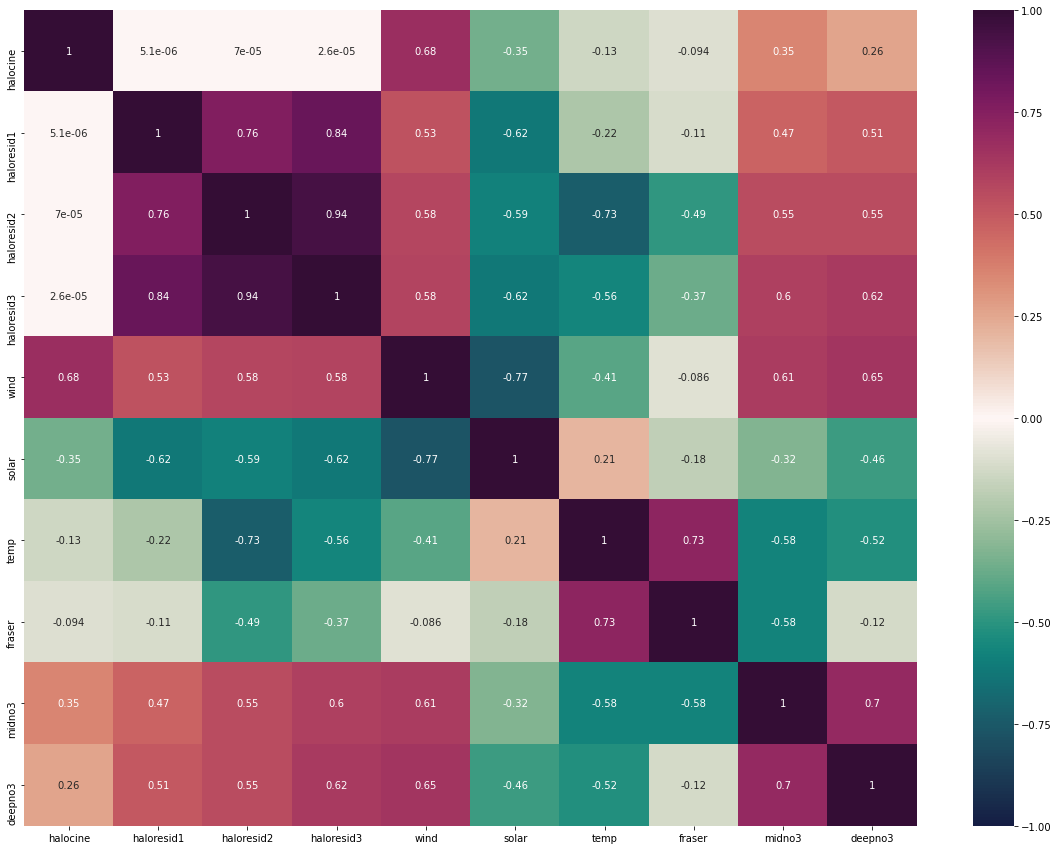

In [88]:
plt.subplots(figsize=(20,15))
cm1=cmocean.cm.curl
sns.heatmap(dfhalo.corr(), annot = True,cmap=cm1,vmin=-1,vmax=1)

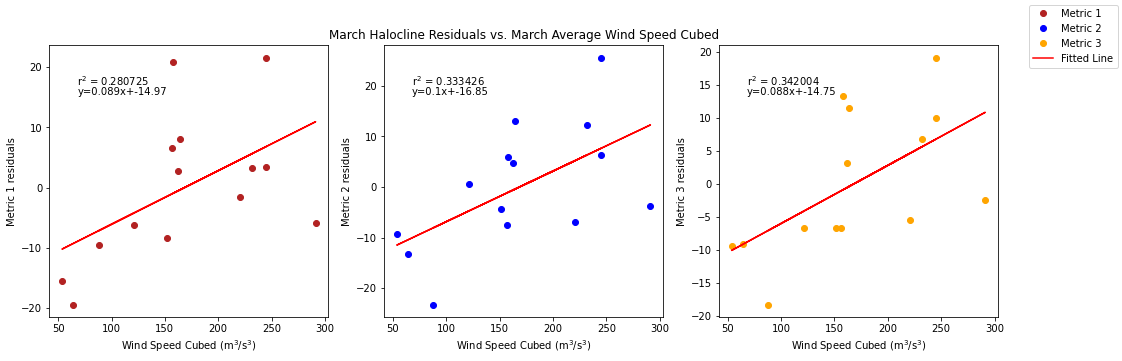

In [89]:
# ---------- wind ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(windmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid1)
ax4[0].plot(windmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(windmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Wind Speed Cubed')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid2)
ax4[1].plot(windmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(windmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Wind Speed Cubed ($\mathregular{m^3}$/$\mathregular{s^3}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(windmar,haloresid3)
ax4[2].plot(windmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

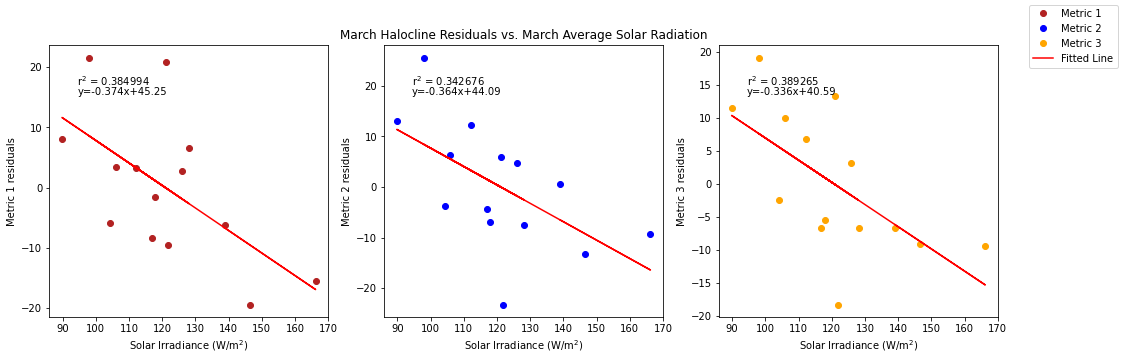

In [90]:
# ---------- Solar ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(solarmar, haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid1)
ax4[0].plot(solarmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(solarmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Solar Radiation')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid2)
ax4[1].plot(solarmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(solarmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Solar Irradiance (W/$\mathregular{m^2}$)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(solarmar,haloresid3)
ax4[2].plot(solarmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

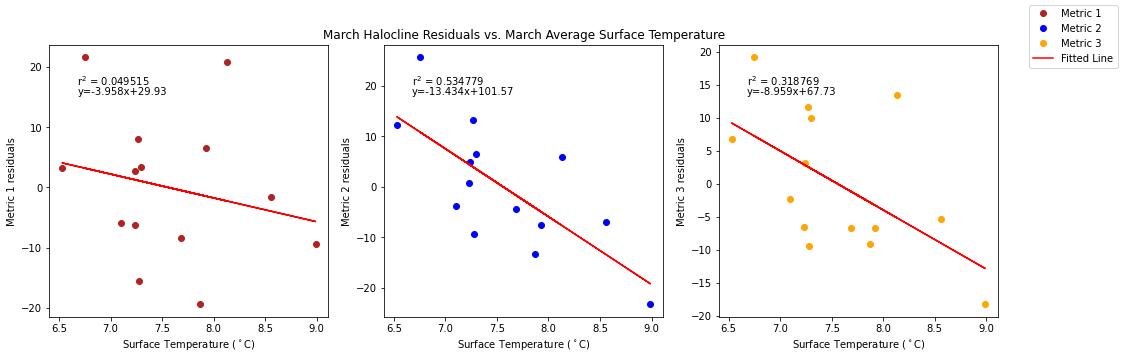

In [91]:
# ---------- Temperature ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(tempmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid1)
ax4[0].plot(tempmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(tempmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Surface Temperature')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid2)
ax4[1].plot(tempmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(tempmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Surface Temperature ($^\circ$C)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(tempmar,haloresid3)
ax4[2].plot(tempmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

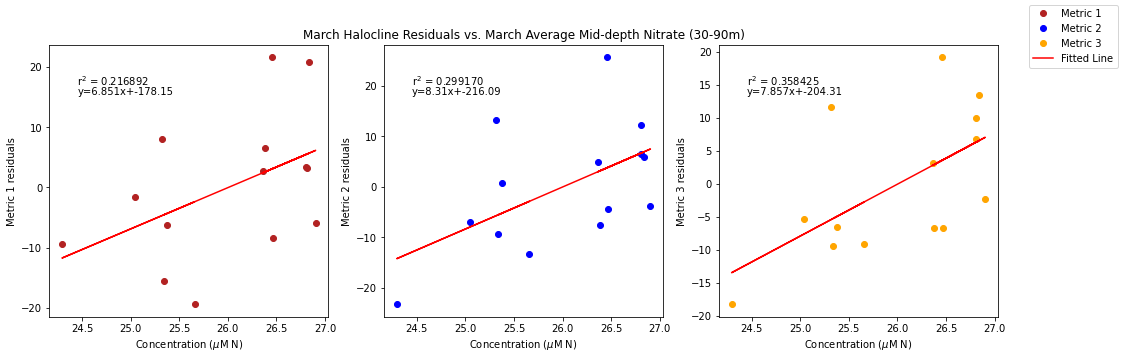

In [92]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(midno3mar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid1)
ax4[0].plot(midno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(midno3mar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Mid-depth Nitrate (30-90m)')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid2)
ax4[1].plot(midno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(midno3mar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(midno3mar,haloresid3)
ax4[2].plot(midno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

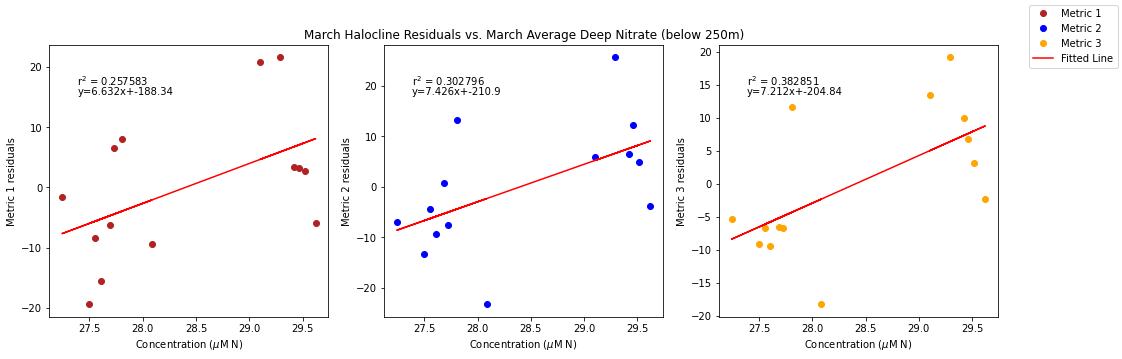

In [93]:
# ---------- Deep NO3 ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(deepno3mar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Concentration ($\mu$M N)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid1)
ax4[0].plot(deepno3mar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(deepno3mar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Concentration ($\mu$M N)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Deep Nitrate (below 250m)')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid2)
ax4[1].plot(deepno3mar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(deepno3mar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Concentration ($\mu$M N)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(deepno3mar,haloresid3)
ax4[2].plot(deepno3mar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

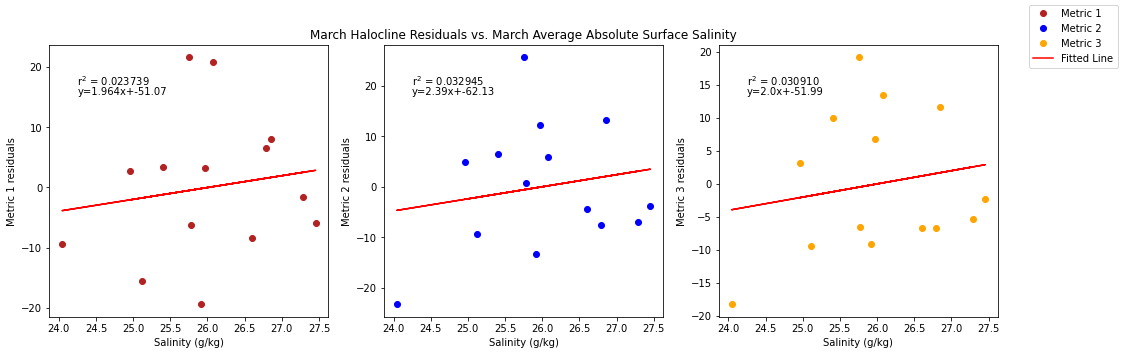

In [94]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

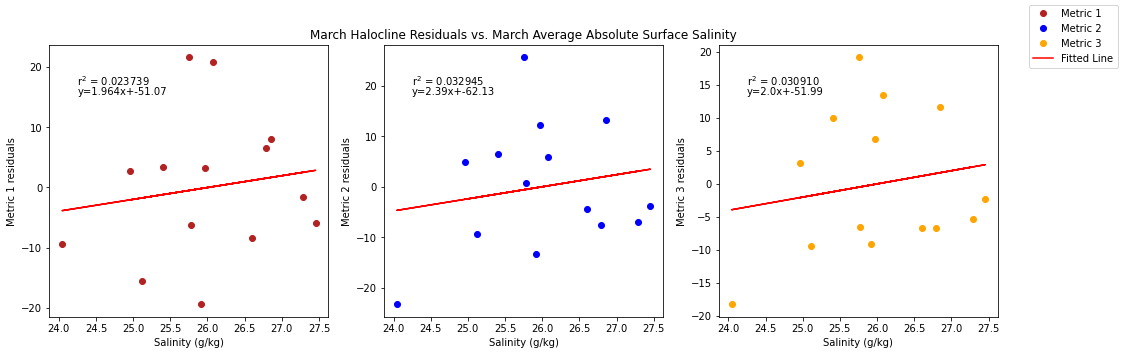

In [95]:
# ---------- Salinity ---------
fig4,ax4=plt.subplots(1,3,figsize=(17,5))
ax4[0].plot(salmar,haloresid1,'o',color='firebrick',label='Metric 1')
ax4[0].set_xlabel('Salinity (g/kg)')
ax4[0].set_ylabel('Metric 1 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid1)
ax4[0].plot(salmar, y, 'r')
ax4[0].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[0].transAxes)
ax4[0].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[0].transAxes)

ax4[1].plot(salmar,haloresid2,'o',color='b',label='Metric 2')
ax4[1].set_xlabel('Salinity (g/kg)')
ax4[1].set_ylabel('Metric 2 residuals')
ax4[1].set_title('March Halocline Residuals vs. March Average Absolute Surface Salinity')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid2)
ax4[1].plot(salmar, y, 'r')
ax4[1].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[1].transAxes)
ax4[1].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[1].transAxes)

ax4[2].plot(salmar,haloresid3,'o',color='orange',label='Metric 3')
ax4[2].set_xlabel('Salinity (g/kg)')
ax4[2].set_ylabel('Metric 3 residuals')
y,r2,m,b=bloomdrivers.reg_r2(salmar,haloresid3)
ax4[2].plot(salmar, y, 'r', label='Fitted Line')
ax4[2].text(0.1, 0.85, '$\mathregular{r^2}$ = %f'%r2, transform=ax4[2].transAxes)
ax4[2].text(0.1,0.81,f'y={m}x+{b}',horizontalalignment='left',verticalalignment='bottom',transform=ax4[2].transAxes)
fig4.legend()

### Multiple linear regression

**Correlation with winds (least to greatest)**
* Fraser, temp, salinity, density diffs, midno3, deepno3, halocline, solar, eddy30, eddy15, turbocline

**Correlation with solar**
* Fraser, temp, midno3, halo, sal, density diffs, deepno3, eddy30, eddy15, turbo, wind

**Correlation with temperature**
* density diffs, salinity, halo, solar, turbo, eddy30, eddy15, wind, deepno3, midno3, fraser

**Correlation with midno3**
* density diffs, solar/salinity, halocline, fraser/temp, turbo/eddy30, wind/eddy15, deepno3

**Correlation with deep no3**
* density diffs, Fraser, salinity, halo, solar, turbo, temp, eddy30/eddy15, wind, midno3

**Correlation with salinity**
* Temp, deepno3, midno3, solar, fraser, wind, eddy30,eddy15, turbo, halo, density diffs

**Correlation with fraser**
* Wind, halo, deepno3, eddy30, eddy15, solar/turbo, density diffs, sal, midno3, temp

**Correlation with halocline**
* Fraser, temp, deep no3, midno3/solar, wind, salinity, density diffs, turbo, eddy15, eddy30


**MLR with wind+fraser, and bloom date:**

In [16]:
A=np.vstack((windmar,frasermar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ 1.18281647e+01 -1.20772740e-02  4.68895740e+01]
r2 value:
[0.81906669]
adjusted r2 value:
[0.80398892]


**MLR with wind+temperature, and bloom date:**

In [17]:
A=np.vstack((windmar,tempmar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[  9.39448798  -9.93383817 121.98763873]
r2 value:
[0.84747012]
adjusted r2 value:
[0.83475929]


**MLR with wind+temperature+fraser, and bloom date:**

In [18]:
A=np.vstack((windmar,tempmar,frasermar,np.ones(np.shape(windmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ 1.00894182e+01 -6.83958574e+00 -5.33442202e-03  1.00646944e+02]
r2 value:
[0.86330235]
adjusted r2 value:
[0.83844823]


**MLR with solar+fraser, and bloom date:**

In [19]:
A=np.vstack((solarmar,frasermar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-5.26190889e-01 -1.74516370e-02  1.80208445e+02]
r2 value:
[0.84034192]
adjusted r2 value:
[0.82703708]


**MLR with solar+temperature, and bloom date:**

In [20]:
A=np.vstack((solarmar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.36624013 -12.17100052 233.89406928]
r2 value:
[0.8191799]
adjusted r2 value:
[0.80411156]


**MLR with solar+fraser+temperature, and bloom date:**

In [21]:
A=np.vstack((solarmar,frasermar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-4.55257248e-01 -1.07715284e-02 -6.04841663e+00  2.10090112e+02]
r2 value:
[0.87381285]
adjusted r2 value:
[0.85086973]


**MLR with solar+wind+fraser, and bloom date:**

In [22]:
A=np.vstack((solarmar,windmar,frasermar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-3.12813307e-01  5.82764415e+00 -1.51406694e-02  1.20438902e+02]
r2 value:
[0.8820992]
adjusted r2 value:
[0.86066269]


**MLR with solar+wind+temperature, and bloom date:**

In [23]:
A=np.vstack((solarmar,windmar,tempmar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[-1.61725140e-01  6.19853288e+00 -1.04690831e+01  1.62842021e+02]
r2 value:
[0.866945]
adjusted r2 value:
[0.84275318]


**MLR with density differences+temperature, and bloom date:**

In [24]:
A=np.vstack((densdiff10mar,tempmar,np.ones(np.shape(densdiff10mar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -7.2427315  -14.01263318 216.67902046]
r2 value:
[0.70621827]
adjusted r2 value:
[0.68173646]


**MLR with midno3+solar, and bloom date:**

In [25]:
A=np.vstack((solarmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.34956828   7.64011715 -58.80837851]
r2 value:
[0.65101475]
adjusted r2 value:
[0.62193265]


**MLR with midno3+wind, and bloom date:**

In [26]:
A=np.vstack((windmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=2 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[  9.97959582   4.05153087 -61.62681161]
r2 value:
[0.66851517]
adjusted r2 value:
[0.64089143]


**MLR with midno3+solar+wind, and bloom date:**

In [27]:
A=np.vstack((solarmar,windmar,midno3mar,np.ones(np.shape(solarmar)))).T
b=yearday2
m=np.linalg.lstsq(A,b,rcond=None)[0]
model, resid = np.linalg.lstsq(A, b,rcond=None)[:2]
r2 = 1 - resid / (len(b) * np.var(b))
p=3 # number of parameters
ar2= 1-(len(b)-1)/(len(b)-p)*(1-r2)
print('Coefficients and intercept:')
print(m)
print('r2 value:')
print(r2)
print('adjusted r2 value:')
print(ar2)

Coefficients and intercept:
[ -0.1627757    6.32181095   5.092185   -49.26038454]
r2 value:
[0.68631239]
adjusted r2 value:
[0.62927828]
